In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
%config InlineBackend.figure_format = 'retina'

Define the make_correlated_arp function to generate correlated AR time series data.

In [165]:
zs = lambda v: (v-v.mean(0))/v.std(0)

def make_pink_noise(nT, beta=1):
    # beta: power law exponent
    freqs = np.fft.rfftfreq(nT)
    freqs[0] = 1
    spectrum = np.random.randn(len(freqs)) + 1j * np.random.randn(len(freqs))
    spectrum /= freqs ** (beta/2)  # power spectrum follos 1/f^beta, amplitude spectrum follows this
    pink_noise = np.fft.irfft(spectrum, n=nT)
    return pink_noise / np.std(pink_noise)

def make_correlated_arp(ar_coeff, nT, n_series, corr=1, noise_std=1, measurement_noise_std=1):
    shared_noise_std = noise_std * np.sqrt(corr)  # shared variability across runs
    unique_noise_std = noise_std * np.sqrt(1 - corr) # independent variability
    
    shared_noise = np.random.randn(nT) * shared_noise_std
    unique_noise = np.random.randn(n_series, nT) * unique_noise_std 

    # Generate measurement noise that is NOT part of the AR process (white or pink)
    white_noise = np.random.randn(n_series,nT) * measurement_noise_std
    # pink_noise = np.array([make_pink_noise(nT) for _ in range(n_series)]) * measurement_noise_std

    time_series = np.zeros((n_series, nT))
    time_series[:,0] = shared_noise[0] + unique_noise[:,0] # first time step

    for t in range(1, nT):
        time_series[:, t] = ar_coeff * time_series[:, t - 1] + shared_noise[t] + unique_noise[:, t]


    noisy_time_series = time_series + white_noise
    # noisy_time_series = time_series + pink_noise

    
    return noisy_time_series


def correct_bias_scale(response_trials, nRuns):
    avg_resp = zs(np.mean(response_trials, axis=0))
    residuals = response_trials - avg_resp
    resp_var = np.sum(residuals**2, axis=0) / (nRuns - 1)
    avg_resp_var = np.mean(resp_var, axis=0)
    
    mean_residuals = np.mean(residuals, axis=0)
    residuals_var = np.sum((residuals - mean_residuals)**2, axis=0) / (nRuns - 1)
    avg_residuals_var = np.mean(residuals_var, axis=0)
    
    # get variance of noise
    sigma_n_sq = avg_residuals_var/(nRuns - 1)  

    # get variance of y_t (signal variance)
    sigma_y_sq = avg_resp_var - sigma_n_sq
    # scale = np.sqrt(1 + (sigma_n_sq / sigma_y_sq))
    scale = 1 + (sigma_n_sq / sigma_y_sq)

    return scale

    


Simulate 10 timeseries, each with 100 timepoints, with diff SNR, and fit AR model to get coefficient estimates.

In [168]:
nLoops = 1000
nT = 100 # number of timepoints
nRuns = 10
real_ar_coeff = np.array([0.1, 0.5, 0.9])
corrs = np.arange(0,1,0.1)
sim_data = np.zeros((nLoops, len(real_ar_coeff), len(corrs), nRuns, nT))
est_ar_coeff = np.zeros((nLoops, len(real_ar_coeff), len(corrs), nRuns))
run_avg_est_ar_coeff = np.zeros((nLoops, len(real_ar_coeff), len(corrs)))
run_avg_scale_corrected_ar_coeff = np.zeros_like(run_avg_est_ar_coeff)

for loop in range(nLoops):
    for coeff in range(len(real_ar_coeff)):
        for corr in range(len(corrs)):
            sim_data[loop, coeff, corr, :, :] = make_correlated_arp(real_ar_coeff[coeff], nT, n_series=nRuns, corr=corrs[corr]) 
            # Average across 10 runs and then fit the AR(1) model
            avg_series = np.mean(sim_data[loop, coeff, corr, :, :], axis=0)
            zs_avg_series = zs(avg_series)
            # print(zs_avg_series.shape)
            ar1_model = sm.tsa.AutoReg(zs_avg_series, lags=1).fit()
            run_avg_est_ar_coeff[loop, coeff, corr] = ar1_model.params[1]

            # Correct for bias with scaling factor 
            scale = correct_bias_scale(sim_data[loop, coeff, corr, :, :],nRuns)
            run_avg_scale_corrected_ar_coeff[loop, coeff, corr] = run_avg_est_ar_coeff[loop, coeff, corr] * scale



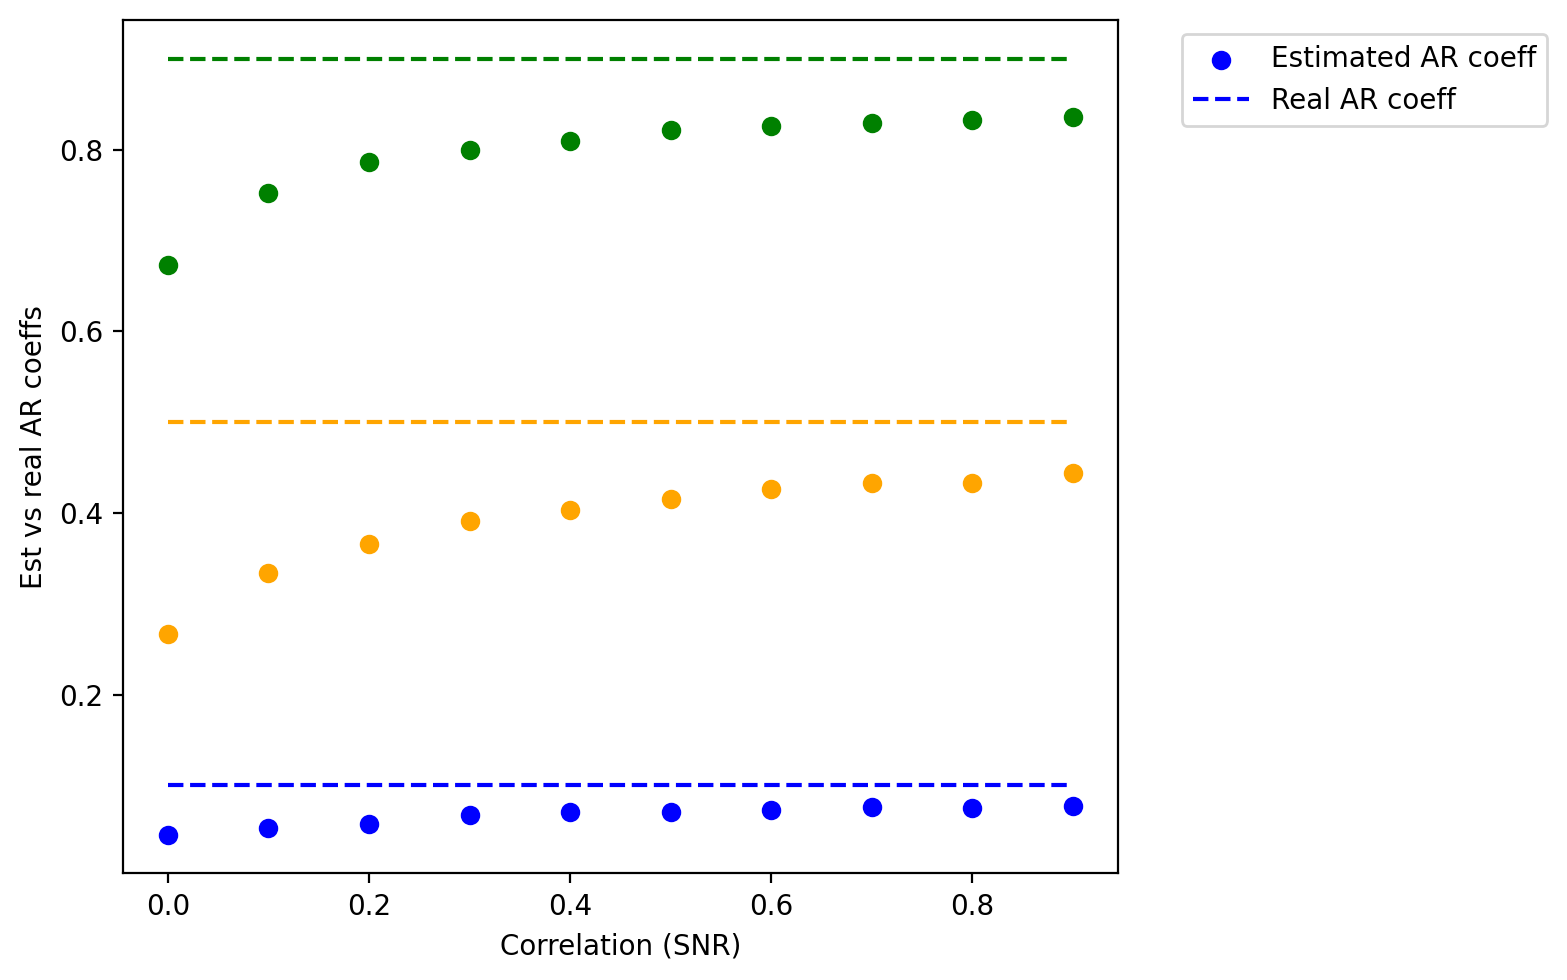

In [169]:
# Plotting
avg_est_ar_coeff = np.mean(run_avg_est_ar_coeff, axis=0)
avg_scale_corrected_ar_coeff = np.mean(run_avg_scale_corrected_ar_coeff, axis=0)

plt.figure(figsize=(8,5))
colors = ['blue', 'orange', 'green']
for coeff in range(len(real_ar_coeff)):
    plt.scatter(corrs, avg_est_ar_coeff[coeff,:], color=colors[coeff], label='Estimated AR coeff' if coeff == 0 else "")
    # plt.scatter(corrs, avg_scale_corrected_ar_coeff[coeff,:], color=colors[coeff], marker='x', label='Corrected AR coeff (scaling)' if coeff == 0 else "")

    plt.plot(corrs, [real_ar_coeff[coeff]] * len(corrs), color=colors[coeff], linestyle='--', label='Real AR coeff' if coeff == 0 else "")
# plt.plot(corrs, [0] * len(corrs), color='black', linestyle='-', label='Zero')
plt.xlabel("Correlation (SNR)")
plt.ylabel("Est vs real AR coeffs")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Est. AR coeffs')

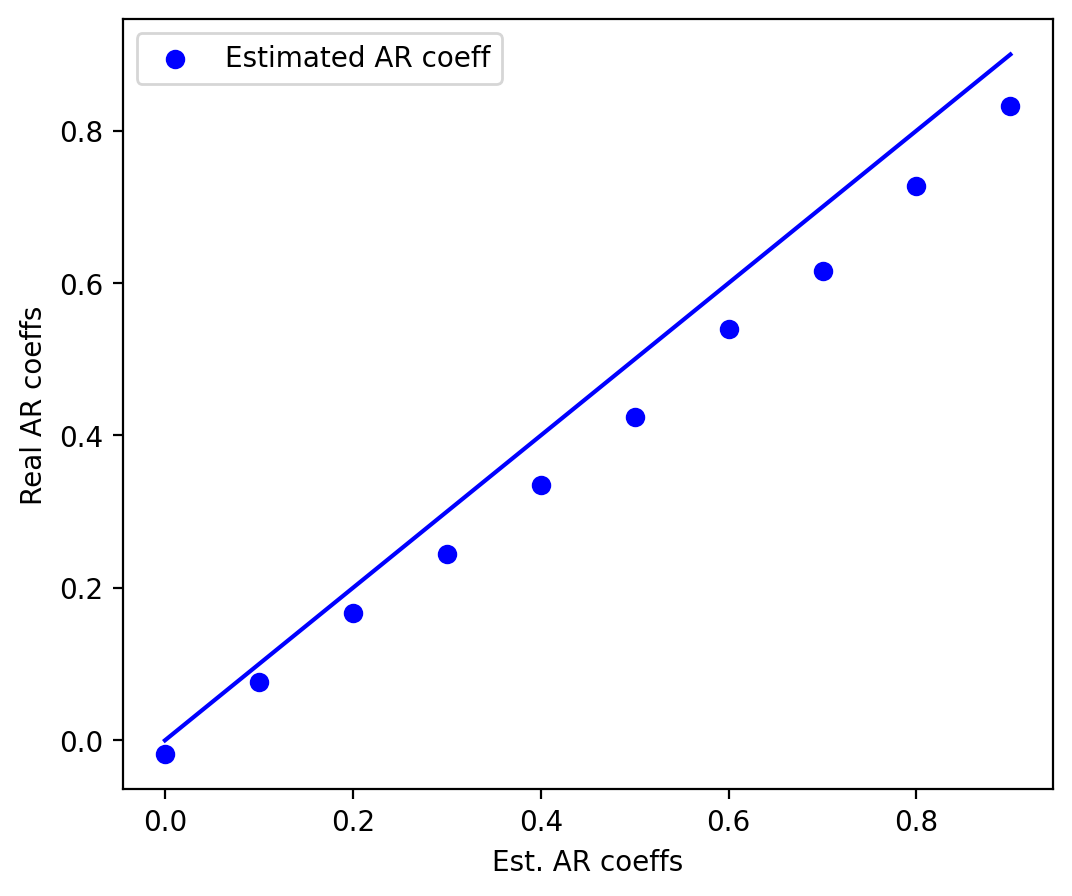

In [167]:
nLoops = 100
nT = 100 # number of timepoints
nRuns = 10
real_ar_coeff = np.arange(0,1,0.1)
sim_data = np.zeros((nLoops, len(real_ar_coeff), nRuns, nT))
est_ar_coeff = np.zeros((nLoops, len(real_ar_coeff)))

for loop in range(nLoops):
    for coeff in range(len(real_ar_coeff)):
        sim_data[loop, coeff, :, :] = make_correlated_arp(real_ar_coeff[coeff], nT, nRuns, corr=0.7)
        zs_avg_resp = zs(np.mean(sim_data[loop,coeff,:,:],axis=0))
        ar1_model = sm.tsa.AutoReg(zs_avg_resp, lags = 1).fit()
        est_ar_coeff[loop,coeff] = ar1_model.params[1]

avg_est_ar_coeff = np.mean(est_ar_coeff,0)

corrected_ar_coeff = np.zeros((nLoops, len(real_ar_coeff)))
for loop in range(nLoops):
    for coeff in range(len(real_ar_coeff)):
        scale = correct_bias_scale(sim_data[loop, coeff, :, :], nRuns)
        corrected_ar_coeff[loop,coeff] = est_ar_coeff[loop, coeff] * scale

avg_corrected_ar_coeff = np.mean(corrected_ar_coeff,0)

plt.figure(figsize=(6,5))
# plt.scatter(avg_corrected_ar_coeff, real_ar_coeff, color='orange', label='Corrected AR coeff (scaling)')
plt.scatter(real_ar_coeff, avg_est_ar_coeff, color='b', label='Estimated AR coeff')
plt.plot(real_ar_coeff, real_ar_coeff,color='b')
plt.legend()
plt.ylabel("Real AR coeffs")
plt.xlabel("Est. AR coeffs")

## Get noise from data and fit an AR(1) to the noise directly

#### Fit ARMA(2,1) to data


##### $$\hat{n_t} = \ z_t^i - \bar{z_t}$$


First, fit an AR process to data $\bar{z_t}$ (signal + noise). Assuming both signal and noise are independent AR(1) processes,  

$$ X_1(t) = \alpha X_1(t-1) + \epsilon_1(t)$$

$$X_2(t) = \beta X_2(t-1) + \epsilon_2(t)$$

Their sum:

$$X(t) = X_1(t) + X_2(t)$$ 

follows an ARMA(2,1) process (Ku & Seneta, 2006):

$$ X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \epsilon_t + \theta \epsilon_{t-1}$$

where the coefficients relate to the original AR(1) processes as:

$$ \phi_1 = \alpha + \beta$$

$$ \phi_2 = -\alpha \beta$$

$$ \theta = \frac{\sigma_1^2 \alpha + \sigma_2^2 \beta}{\sigma_1^2 + \sigma_2^2}$$

where $\sigma_1^2, \sigma_2^2$ are the variances of the white noise terms.


##### Then, solve for $\alpha, \beta $:

From the first two equations:

$$\alpha + \beta = \phi_1$$

$$\alpha \beta = -\phi_2$$

Rearrange into a quadratic equation:

$$ \alpha^2 - \alpha \phi_1  - \phi_2 = 0$$

*Note:* for an ARMA(2,1) process to be stationary and the roots of $1 - \phi_{1}z - \phi_{2}z_2 = 0$ to be real, it is necessary and sufficient that
$$ \phi_1^2 + 4\phi_2 > 0,  \phi_1 + \phi_2 < 1,  \phi_2 - \phi_1 < 1$$

Solving for $\alpha, \beta$:

$$\alpha = \frac{\phi_1 \pm \sqrt{\phi_1^2 + 4\phi_2}}{2}$$

$$ \beta = \frac{\phi_2}{-\alpha}$$ 
$$\beta = \phi_1 - \alpha $$


To verify these relationships, first simulate two AR(1) processes with ground truth $\alpha, \beta$ and sum them together. Then fit an ARMA(2,1) to the sum, see if we can recover $\alpha, \beta$ from the relationships derived above.

In [ ]:
import numpy as np
# Generate two AR(1) time series: one as signal and one as noise, with an option to control correlation, and return their sum as noisy_signal.
def make_ar1s(alpha, beta, nT, signal_corr, noise_corr, nRuns=10, signal_std=1, noise_std=1):

    # compute shared and unique components for both signal and noise
    shared_signal_std = np.sqrt(signal_corr) * signal_std
    unique_signal_std = np.sqrt(1 - signal_corr) * signal_std

    shared_noise_std = np.sqrt(noise_corr) * noise_std
    unique_noise_std = np.sqrt(1 - noise_corr) * noise_std  
    
    # generate shared components (shared across all runs, that's why we only generate these once)
    shared_signal_noise = np.random.randn(nT) * shared_signal_std
    shared_noise_noise = np.random.randn(nT) * shared_noise_std

    # generate AR(1) processes
    signals = np.zeros((nRuns, nT))
    noises = np.zeros((nRuns, nT))
    noisy_signals = np.zeros((nRuns, nT))

    for run in range(nRuns):
        # generate unique, independent noise per run
        unique_signal_noise = np.random.randn(nT) * unique_signal_std
        unique_noise_noise = np.random.randn(nT) * unique_noise_std

        for t in range(1, nT):
            signals[run, t] = alpha * signals[run, t - 1] + shared_signal_noise[t] + unique_signal_noise[t]
            noises[run, t] = beta * noises[run, t - 1] + shared_noise_noise[t] + unique_noise_noise[t]
    
        # Sum to create the noisy signal
        noisy_signals[run,:] = signals[run,:] + noises[run,:]
    
    return signals, noises, noisy_signals

Simulate time series data (the sum of two AR(1) processes) and fit ARMA(2,1) to test how well it can recover alpha and beta

In [ ]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

alpha = 0.8
beta = 0.3
nT = 300
nBoots = 100
signal_corr = 0.7
noise_corr= 0.3

alpha_recovered = np.zeros((nBoots,))
beta_recovered1 = np.zeros((nBoots,))
beta_recovered2 = np.zeros((nBoots,))
num_failures = 0  
eps = 1e-6  

for i in range(nBoots):
    signals, noises, noisy_signals = make_ar1s(alpha, beta, nT, signal_corr, noise_corr)
    # Fit ARMA(2,1) model to noisy_signal
    noisy_signal = zs(np.mean(noisy_signals, axis=0))
    model = SARIMAX(noisy_signal, order=(2, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
    arma_result = model.fit()

    # Check if optimization failed
    if not arma_result.mle_retvals['converged']:
        num_failures += 1
        print(f"Warning: Fit failed on iteration {i}. Estimated parameters: {arma_result.params}")
        continue

    # Extract estimated parameters
    if len(arma_result.params) >= 3:
        phi_1 = arma_result.params[0]
        phi_2 = arma_result.params[1]
        theta = arma_result.params[2]
    else:
        num_failures += 1
        continue

    # Check stationarity conditions
    D = phi_1**2 + 4 * phi_2
    if D <= 0 or (phi_1 + phi_2 >= 1) or (phi_2 - phi_1 >= 1):
        num_failures += 1
        continue  # Skip this iteration if conditions are not met

    # Compute recovered AR(1) coefficients
    alpha_recovered[i] = (phi_1 + np.sqrt(D)) / 2
    beta_recovered1[i] = phi_2 / (-alpha_recovered[i] + eps)
    beta_recovered2[i] = phi_1 - alpha_recovered[i]

# Print summary statistics after the loop
print(f"Failed convergences or discarded trials: {num_failures} out of {nBoots}")
print(f"Mean alpha_recovered: {np.mean(alpha_recovered[alpha_recovered > 0])}")
print(f"Mean beta_recovered1: {np.mean(beta_recovered1[beta_recovered1 > 0])}")
print(f"Mean beta_recovered2: {np.mean(beta_recovered2[beta_recovered2 > 0])}")

/Users/jiamingxu/miniconda3/envs/language_straightening_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jiamingxu/miniconda3/envs/language_straightening_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jiamingxu/miniconda3/envs/language_straightening_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed convergences or discarded trials: 2 out of 100
Mean alpha_recovered: 0.7786612792746955
Mean beta_recovered1: 0.3396314819810229
Mean beta_recovered2: 0.3396310940400357


The estimates are pretty accurate. This tells us that if the time series data is in fact ARMA(2,1), we should be able to accurately recover the signal and noise coefficients. 

Next, try fitting AR(1) to noise directly, and get an estimate of beta. 

In [ ]:
# this fit AR to noise in each trial, and then get the average of beta estimate 
def fit_ind_noise_to_ar1(response_trials, nRuns):
    avg_resp = zs(np.mean(response_trials, axis=0))
    noise_lb = response_trials - avg_resp 
    noise_ub = np.zeros_like(noise_lb)
    est_beta_lb = []
    est_beta_ub = []
    for i in range(nRuns):
        ar1_model_lb = sm.tsa.AutoReg(zs(noise_lb[i]), lags=1).fit()
        est_beta_lb.append(ar1_model_lb.params[1])
        jackknife_mean = np.mean(np.delete(response_trials, i, axis=0), axis=0)
        noise_ub[i] = response_trials[i,:] - jackknife_mean
        ar1_model_ub = sm.tsa.AutoReg(zs(noise_ub[i]), lags=1).fit()
        est_beta_ub.append(ar1_model_ub.params[1])

    mean_beta_lb = np.mean(est_beta_lb)
    mean_beta_ub = np.mean(est_beta_ub)

    return mean_beta_lb, mean_beta_ub

The noise AR(1) coeff estimation works pretty well too. 
- simply adding beta estimates to alpha estimates from fitting AR(1) does not work. Try simulating the relationship between alpha and beta estimates and apply correction that way. 


Next, fit the same ARMA(2,1) model to the simulated data with different SNR, and see how accurately the model can estimate the ground truth alphas that are used to generate data. 

Here, I tried two different approaches:
1. fit data to ARMA(2,1) and calculate alpha and beta directly
2. fit data to ARMA(2,1), fit noise to AR(1), get beta estimate first, and calculating alpha based on the beta estimate

In [220]:
##### Assuming stationarity met #######
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, yule_walker
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")


def initialize_arma_params(series):
    # AR(2) coeff 
    phi_init, _ = yule_walker(series, order=2)
    # MA(1) coeff
    acf_values = acf(series, nlags=1)
    theta_init = -acf_values[1]
    
    return [phi_init[0], phi_init[1], theta_init]

nLoops = 100
nT = 100  # number of timepoints
nRuns = 10
true_alpha = np.array([0.1, 0.5, 0.9])
corrs = np.arange(0, 1, 0.1)
sim_data = np.zeros((nLoops, len(true_alpha), len(corrs), nRuns, nT))

num_failures = 0
non_stationary_count = 0
alpha_recovered = np.zeros((nLoops, len(true_alpha), len(corrs)))
beta_recovered1 = np.zeros((nLoops, len(true_alpha), len(corrs)))
beta_recovered2 = np.zeros((nLoops, len(true_alpha), len(corrs)))
phi_1_recovered = np.zeros((nLoops, len(true_alpha), len(corrs)))
phi_2_recovered = np.zeros((nLoops, len(true_alpha), len(corrs)))
theta_recovered = np.zeros((nLoops, len(true_alpha), len(corrs)))

est_beta_lb = np.zeros((nLoops, len(true_alpha), len(corrs)))
est_beta_ub = np.zeros((nLoops, len(true_alpha), len(corrs)))

alpha_ar1 = np.zeros((nLoops, len(true_alpha), len(corrs)))

small_eps = 1e-6  # Avoid division by zero

for loop in range(nLoops):
    for coeff in range(len(true_alpha)):
        for corr in range(len(corrs)):
            # Generate correlated ARP data
            sim_data[loop, coeff, corr, :, :] = make_correlated_arp(
                true_alpha[coeff], nT, n_series=nRuns, corr=corrs[corr]
            )
            # Fit AR(1) to noise
            est_beta_lb[loop, coeff, corr], est_beta_ub[loop, coeff, corr] = fit_ind_noise_to_ar1(sim_data[loop, coeff, corr, :, :], nRuns)

            # Average across 10 runs 
            avg_series = np.mean(sim_data[loop, coeff, corr, :, :], axis=0)
            zs_avg_series = zs(avg_series)
            
            # Fit AR(1) to run average
            ar1_model = sm.tsa.AutoReg((zs_avg_series), lags=1).fit()
            alpha_ar1[loop, coeff, corr] = ar1_model.params[1]

            # Fit ARMA(2,1) to run average
            try:
                model = SARIMAX(
                    zs_avg_series, order=(2, 0, 1), trend='n',
                    enforce_stationarity=True, enforce_invertibility=True
                )

                init_params = model.start_params
                # arma_result = model.fit(start_params=[0.3, -0.1, 0.1, 1.0], method='powell', maxiter=500, disp=False)
                #arma_result = model.fit(start_params=init_params, method='lbfgs', disp=False)
                arma_result = model.fit(start_params=init_params, method='powell', maxiter=500, disp=False)


                # Check if optimization converged
                if not arma_result.mle_retvals.get('converged', False):
                    num_failures += 1
                    print(f"Warning: Fit failed on loop {loop}, coeff {coeff}, corr {corr}.")
                    continue

                # Extract estimated parameters
                phi_1, phi_2, theta = arma_result.params[:3]

                # Check stationarity conditions for AR(2) process
                D = phi_1**2 + 4 * phi_2
                if D <= 0 or (phi_1 + phi_2 >= 1) or (phi_2 - phi_1 >= 1):
                    num_failures += 1
                    continue  # Skip iteration if conditions are not met

                # Compute recovered AR(1) coefficients
                alpha_recovered[loop, coeff, corr] = (phi_1 + np.sqrt(D)) / 2
                beta_recovered1[loop, coeff, corr] = phi_2 / (-alpha_recovered[loop, coeff, corr] + small_eps)
                beta_recovered2[loop, coeff, corr] = phi_1 - alpha_recovered[loop, coeff, corr]
                phi_1_recovered[loop, coeff, corr] = phi_1
                phi_2_recovered[loop, coeff, corr] = phi_2 
                theta_recovered[loop, coeff, corr] = theta

            except Exception as e:
                num_failures += 1
                print(f"Error in loop {loop}, coeff {coeff}, corr {corr}: {e}")

failure_rate = (num_failures / (nLoops * len(true_alpha) * len(corrs))) * 100
print(f"Total failed optimizations: {num_failures}/{nLoops * len(true_alpha) * len(corrs)} ({failure_rate:.2f}%)")

# Plotting 
# Compute mean values across loops
avg_alpha_ar1 = np.mean(alpha_ar1, axis=0)
# estimating alpha and beta directly from ARMA fits
avg_alpha_recovered = np.mean(alpha_recovered, axis=0)
avg_beta_recovered = np.mean((beta_recovered1 + beta_recovered2) / 2, axis=0)  # Average of beta estimates
# fitting AR(1) to noise and calculate alpha           
avg_beta_fitted = np.mean(est_beta_ub, axis=0)
alpha_calculated =  np.mean(phi_1_recovered, axis=0) - avg_beta_fitted
# alpha_calculated = -np.mean(phi_2_recovered, axis=0)/avg_beta_fitted

# Define colors for different true alpha values
colors = ['blue', 'orange', 'green']

# Create figure with two subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot estimated alpha values
for coeff in range(len(true_alpha)):
    axes[0].scatter(corrs, avg_alpha_recovered[coeff, :], color=colors[coeff], marker='x',
                    label=f'Estimated alpha from ARMA' if coeff == 0 else "")
    axes[0].scatter(corrs, avg_alpha_ar1[coeff,:], color=colors[coeff], marker='^',
                    label=f'Estimated alpha from AR(1)' if coeff == 0 else "")
    axes[0].plot(corrs, [true_alpha[coeff]] * len(corrs), color=colors[coeff], linestyle='--',
                 label=f'Real alpha' if coeff == 0 else "")

# Labels and legend for alpha plot
axes[0].set_xlabel("Correlation (SNR)")
axes[0].set_ylabel("Estimated Coefficients")
axes[0].set_title("Estimated vs Real Alpha from fitting ARMA and AR(1)")
axes[0].set_ylim([-0.5,1])
axes[0].legend()

# Plot estimated beta values
for coeff in range(len(true_alpha)):
    axes[1].scatter(corrs, avg_beta_recovered[coeff, :], color=colors[coeff], marker='o',
                    label=f'Estimated beta from ARMA' if coeff == 0 else "")

# Labels and legend for beta plot
axes[1].set_xlabel("Correlation (SNR)")
axes[1].set_title("Estimated Beta from fitting ARMA")
axes[1].set_ylim([-0.5,1])
axes[1].legend()

for coeff in range(len(true_alpha)):
    axes[2].scatter(corrs, alpha_calculated[coeff, :], color=colors[coeff], marker='x',
                    label=f'Alpha calculated from fitting noise to AR(1)' if coeff == 0 else "")
    axes[2].plot(corrs, [true_alpha[coeff]] * len(corrs), color=colors[coeff], linestyle='--',
                 label=f'Real alpha' if coeff == 0 else "")

# Labels and legend for alpha plot
axes[2].set_xlabel("Correlation (SNR)")
axes[2].set_ylabel("Estimated Coefficients")
axes[2].set_title("Estimated vs Real Alpha Coefficients (calculated from beta)")
axes[2].set_ylim([-0.5,1])
axes[2].legend()

# Plot estimated beta values
for coeff in range(len(true_alpha)):
    axes[3].scatter(corrs, avg_beta_fitted[coeff, :], color=colors[coeff], marker='o', alpha=0.2,
                    label=f'Estimated beta from AR(1)' if coeff == 0 else "")
    axes[3].scatter(corrs, avg_alpha_ar1[coeff,:], color=colors[coeff], marker='^',
                    label=f'Estimated alpha from AR(1)' if coeff == 0 else "")
    axes[3].plot(corrs, [true_alpha[coeff]] * len(corrs), color=colors[coeff], linestyle='--')
# axes[3].plot(corrs, [0] * len(corrs), color='k', linestyle='-')
# Labels and legend for beta plot
axes[3].set_xlabel("Correlation (SNR)")
axes[3].set_title("Estimated Beta from fitting AR(1) to noise")
axes[3].set_ylim([-0.5,1])
axes[3].legend()

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

That didn't work well. Let's try something else.

#### Fit AR(1) and ARMA(2,1) to the data, verify it lies between true alpha and beta values

#### Train Bayesian decoders
Train Bayesian decoders to learn the mapping between alpha_est -> true alpha and beta_est -> true alpha.

Simulate the full dataset here:

In [222]:
nLoops = 500
nT = 100 # number of timepoints
nRuns = 10
real_ar_coeff = np.arange(0.1,1,0.1)
corrs = np.arange(0,1,0.1)
sim_data = np.zeros((nLoops, len(real_ar_coeff), len(corrs), nRuns, nT))
est_beta_lb = np.zeros((nLoops, len(real_ar_coeff), len(corrs)))
est_beta_ub = np.zeros((nLoops, len(real_ar_coeff), len(corrs)))

run_avg_est_ar_coeff = np.zeros((nLoops, len(real_ar_coeff), len(corrs)))

for loop in range(nLoops):
    for coeff in range(len(real_ar_coeff)):
        for corr in range(len(corrs)):
            sim_data[loop, coeff, corr, :, :] = make_correlated_arp(real_ar_coeff[coeff], nT, n_series=nRuns, corr=corrs[corr]) 
            est_beta_lb[loop, coeff, corr], est_beta_ub[loop, coeff, corr] = fit_ind_noise_to_ar1(sim_data[loop, coeff, corr, :, :], nRuns)
            
            # Average across 10 runs and then fit the AR(1) model
            avg_series = np.mean(sim_data[loop, coeff, corr, :, :], axis=0)
            zs_avg_series = zs(avg_series)
            ar1_model = sm.tsa.AutoReg(zs_avg_series, lags=1).fit()
            run_avg_est_ar_coeff[loop,coeff, corr] = ar1_model.params[1]


KeyboardInterrupt: 

IndexError: index 3 is out of bounds for axis 0 with size 3

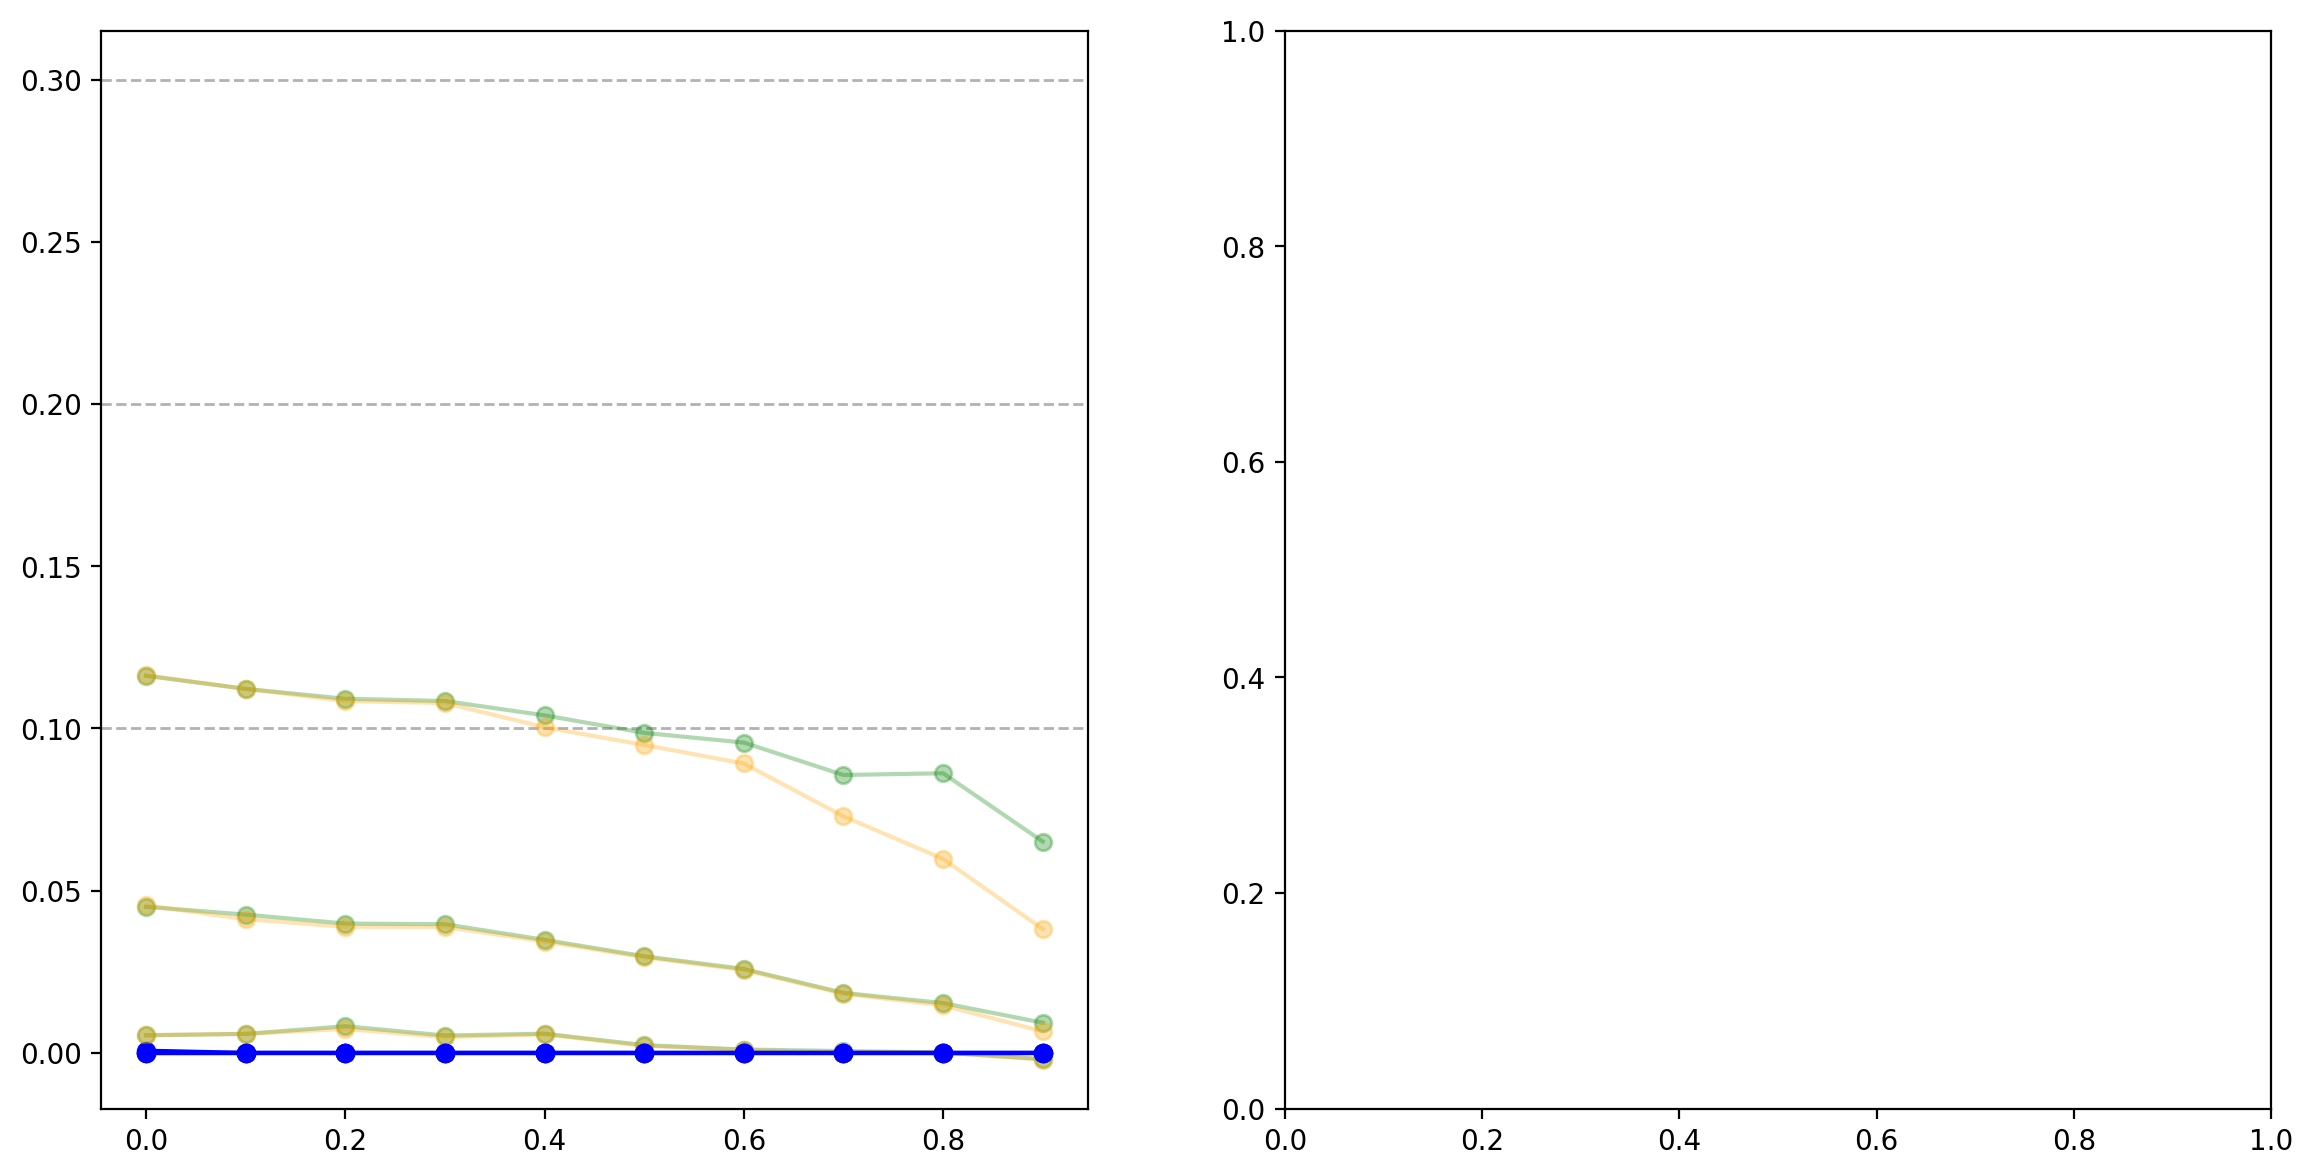

In [221]:
# Plotting
avg_est_beta_lb = np.mean(est_beta_lb, axis=0)
avg_est_beta_ub = np.mean(est_beta_ub, axis=0)
avg_est_ar_coeff = np.mean(run_avg_est_ar_coeff, axis=0)
opacity = np.arange(0,1,0.1)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
# First subplot: Noise AR(1) coefficient estimates
for coeff in range(len(real_ar_coeff)):
    axes[0].plot(corrs, avg_est_ar_coeff[coeff,:],'o-', color='blue', label='Signal AR(1) Coeff Estimate' if coeff == 0 else "")
    axes[0].plot(corrs, avg_est_beta_lb[coeff,:], 'o-', color='green', alpha=0.3, label='Noise AR(1) Coeff Estimate (LB)' if coeff == 0 else "")
    axes[0].plot(corrs, avg_est_beta_ub[coeff,:], 'o-', color='orange', alpha=0.3,  label='Noise AR(1) Coeff Estimate (jackknife)' if coeff == 0 else "")
    axes[0].axhline(y=real_ar_coeff[coeff],color='black', alpha=0.3, linewidth='1', linestyle='--', label='Real AR Coeff' if coeff == 0 else "")
axes[0].set_ylim([-0.1,1])
axes[0].set_xlabel("Correlation (SNR)")
axes[0].set_ylabel("Estimated AR(1) Coeff for Noise")
axes[0].legend(loc='upper left')
axes[0].set_title("Noise AR(1) Coefficient Estimates")

# Second subplot: Signal AR(1) coefficient estimates
for coeff in range(len(real_ar_coeff)):
    axes[1].axhline(y=real_ar_coeff[coeff], color='black', alpha=0.3, linewidth='0.75', linestyle='--')
    axes[1].axvline(x=real_ar_coeff[coeff], color='black', alpha=0.3, linewidth='0.75', linestyle='--')

    for corr in range(len(corrs)):
        axes[1].scatter(avg_est_beta_ub[coeff,corr], avg_est_ar_coeff[coeff, corr], color='blue', alpha=opacity[corr])        

axes[1].set_ylabel("Alpha estimate (signal)")
axes[1].set_xlabel("Beta estimate (noise)")
axes[1].set_title("Relationship Between Signal and Noise AR(1) Coefficients")
axes[1].legend(loc='upper right')
axes[1].set_xlim([-0.1,1])
axes[1].set_ylim([-0.1,1])
axes[1].set_yticks(corrs)
axes[1].set_xticks(corrs)
plt.tight_layout()
plt.show()

In [ ]:
# Train decoders with previously simulated data
from sklearn.neighbors import KernelDensity

real_ar_coeff = np.arange(0.1,1,0.1)

# Dictionary to store beta samples for each alpha
beta_by_alpha = {}
alpha_by_alpha = {}

# Fill dictionary from your simulation
for i, alpha in enumerate(real_ar_coeff):
    beta_vals = est_beta_ub[:, i, :].reshape(-1)  # all beta estimates for this alpha
    beta_by_alpha[alpha] = beta_vals
    alpha_vals = run_avg_est_ar_coeff[:, i, :].reshape(-1)
    alpha_by_alpha[alpha] = alpha_vals


# Store KDE models for each alpha
kde_by_beta = {}
kde_by_alpha = {}

for alpha in real_ar_coeff:
    # fit beta model 
    kde_beta = KernelDensity(kernel='gaussian', bandwidth=0.1)  
    beta_samples = np.array(beta_by_alpha[alpha]).reshape(-1, 1)
    kde_beta.fit(beta_samples)
    kde_by_beta[float(alpha)] = kde_beta

    # fit alpha model 
    kde_alpha = KernelDensity(kernel='gaussian', bandwidth=0.1)  
    alpha_samples = np.array(alpha_by_alpha[alpha]).reshape(-1, 1)
    kde_alpha.fit(alpha_samples)
    kde_by_alpha[float(alpha)] = kde_alpha

# Uniform prior over alphas
prior_alpha = {float(alpha): 1 / len(real_ar_coeff) for alpha in real_ar_coeff}


def decode_alpha_from_beta(beta_obs, kde_by_beta, prior_alpha):
    posterior_unnormalized = {}
    
    for alpha in real_ar_coeff:
        alpha = float(alpha)
        log_likelihood = kde_by_beta[alpha].score_samples(np.array([[beta_obs]]))[0]
        likelihood = np.exp(log_likelihood)
        posterior_unnormalized[alpha] = likelihood * prior_alpha[alpha]

    # Normalize
    total = sum(posterior_unnormalized.values())
    posterior = {alpha: val / total for alpha, val in posterior_unnormalized.items()}

    # Return expected alpha (posterior mean)
    expected_alpha = sum(alpha * prob for alpha, prob in posterior.items())
    best_alpha = max(posterior, key=posterior.get)  # mode of posterior
    return best_alpha

def decode_alpha_from_alpha(alpha_obs, kde_by_alpha, prior_alpha):
    posterior_unnormalized = {}
    
    for alpha in real_ar_coeff:
        alpha = float(alpha)
        log_likelihood = kde_by_alpha[alpha].score_samples(np.array([[alpha_obs]]))[0]
        likelihood = np.exp(log_likelihood)
        posterior_unnormalized[alpha] = likelihood * prior_alpha[alpha]

    # Normalize
    total = sum(posterior_unnormalized.values())
    posterior = {alpha: val / total for alpha, val in posterior_unnormalized.items()}

    # Return expected alpha (posterior mean)
    expected_alpha = sum(alpha * prob for alpha, prob in posterior.items())
    best_alpha = max(posterior, key=posterior.get)  # mode of posterior
    return best_alpha



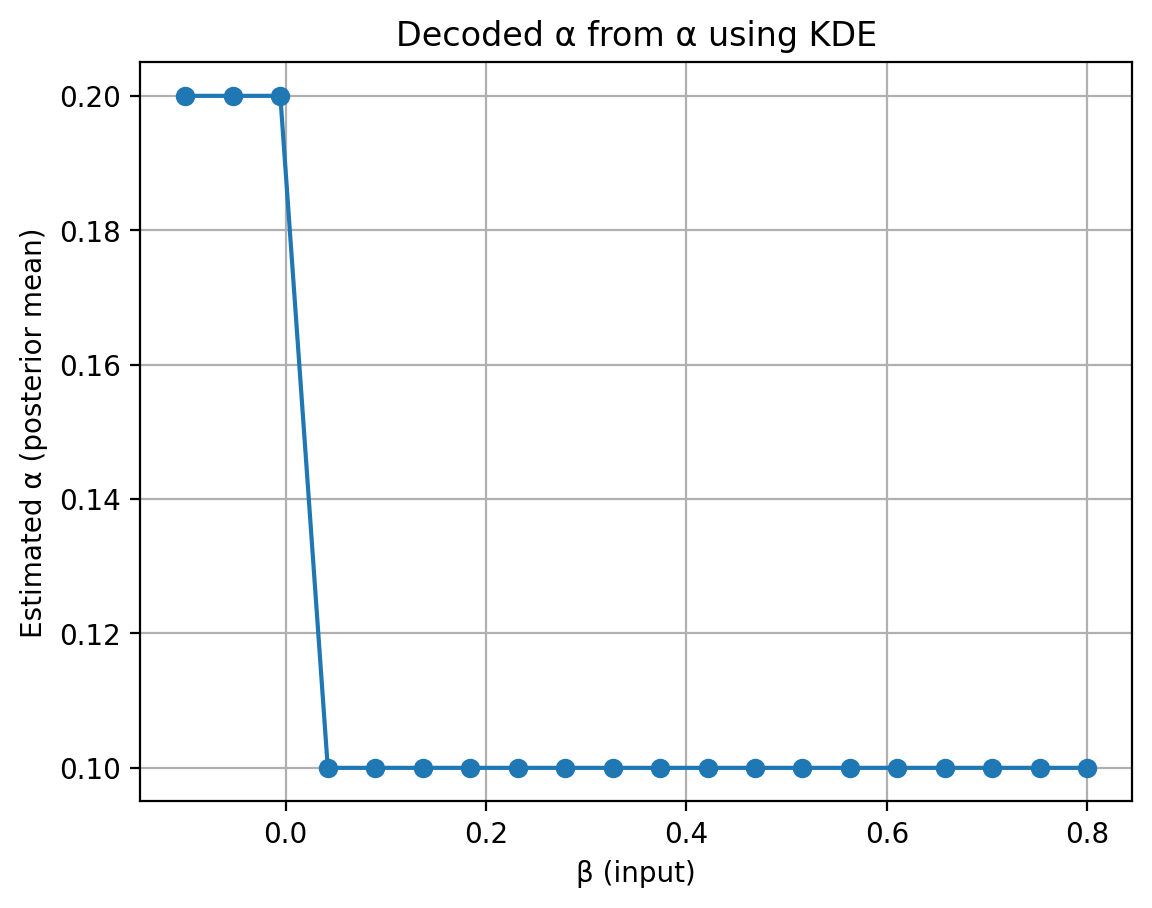

In [214]:
test_betas = np.linspace(-0.1, 0.8, 20)
decoded = [decode_alpha_from_beta(b, kde_by_alpha, prior_alpha) for b in test_betas]

plt.plot(test_betas, decoded, marker='o')
plt.xlabel("β (input)")
plt.ylabel("Estimated α (posterior mean)")
# plt.title("Decoded α from β using KDE")
plt.title("Decoded α from α using KDE")
plt.grid(True)
plt.show()


Visualize the likelihood functions learned by the decoders

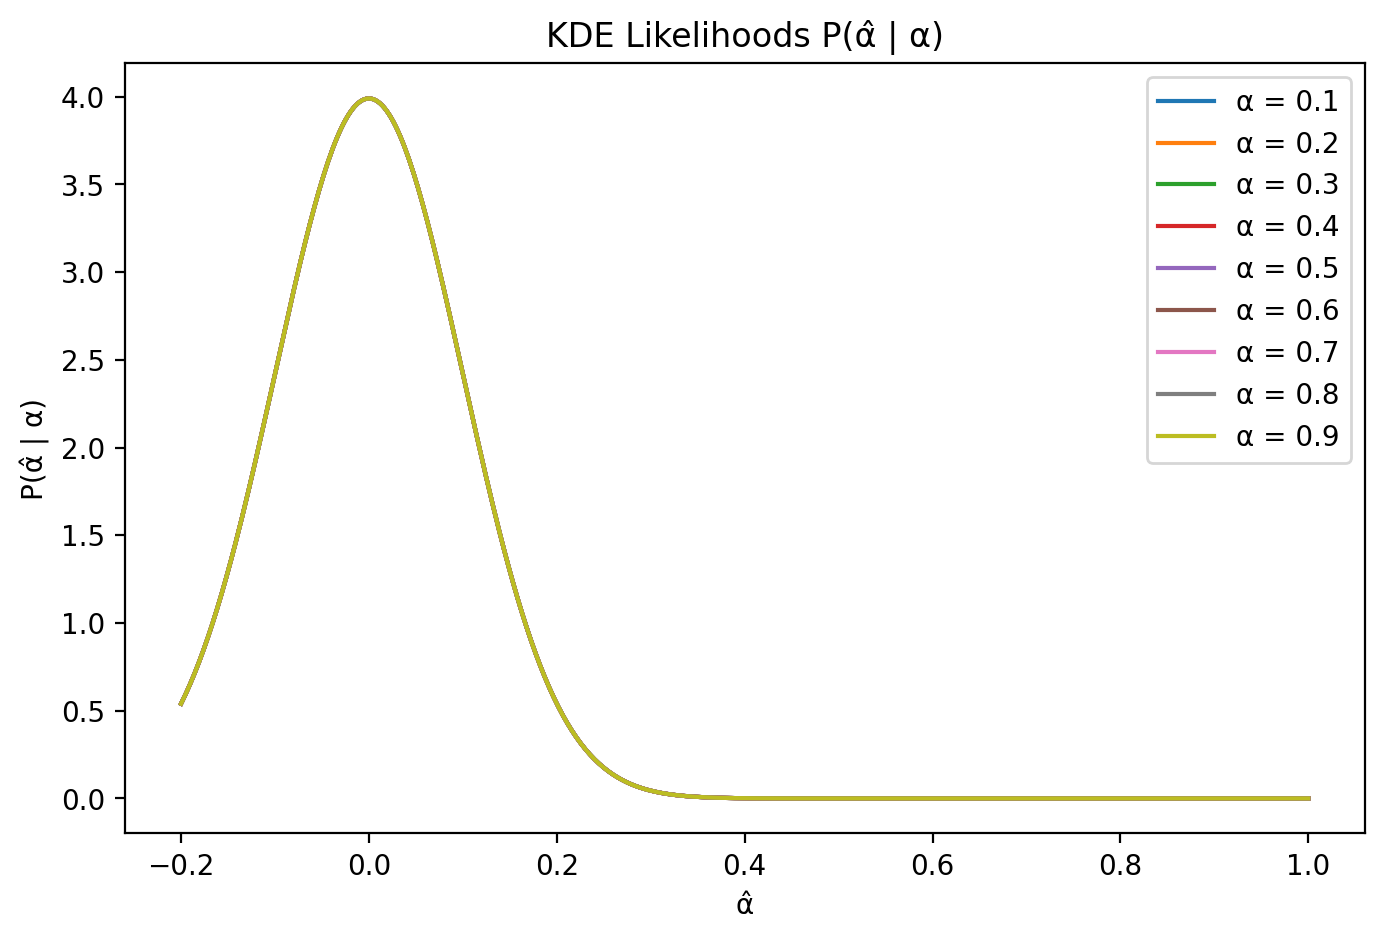

In [215]:
x_vals = np.linspace(-0.2, 1.0, 500).reshape(-1, 1)
plt.figure(figsize=(8, 5))
for alpha in real_ar_coeff:
    alpha = float(alpha)
    log_dens = kde_by_alpha[alpha].score_samples(x_vals)
    plt.plot(x_vals, np.exp(log_dens), label=f'α = {alpha:.1f}')
# plt.xlabel('β (estimated)')
plt.xlabel('α̂')
# plt.ylabel('P(β | α)')
plt.ylabel('P(α̂ | α)')
# plt.title('KDE Likelihoods P(β | α)')
plt.title('KDE Likelihoods P(α̂ | α)')
plt.legend()
plt.show()

Visualize the posteriors

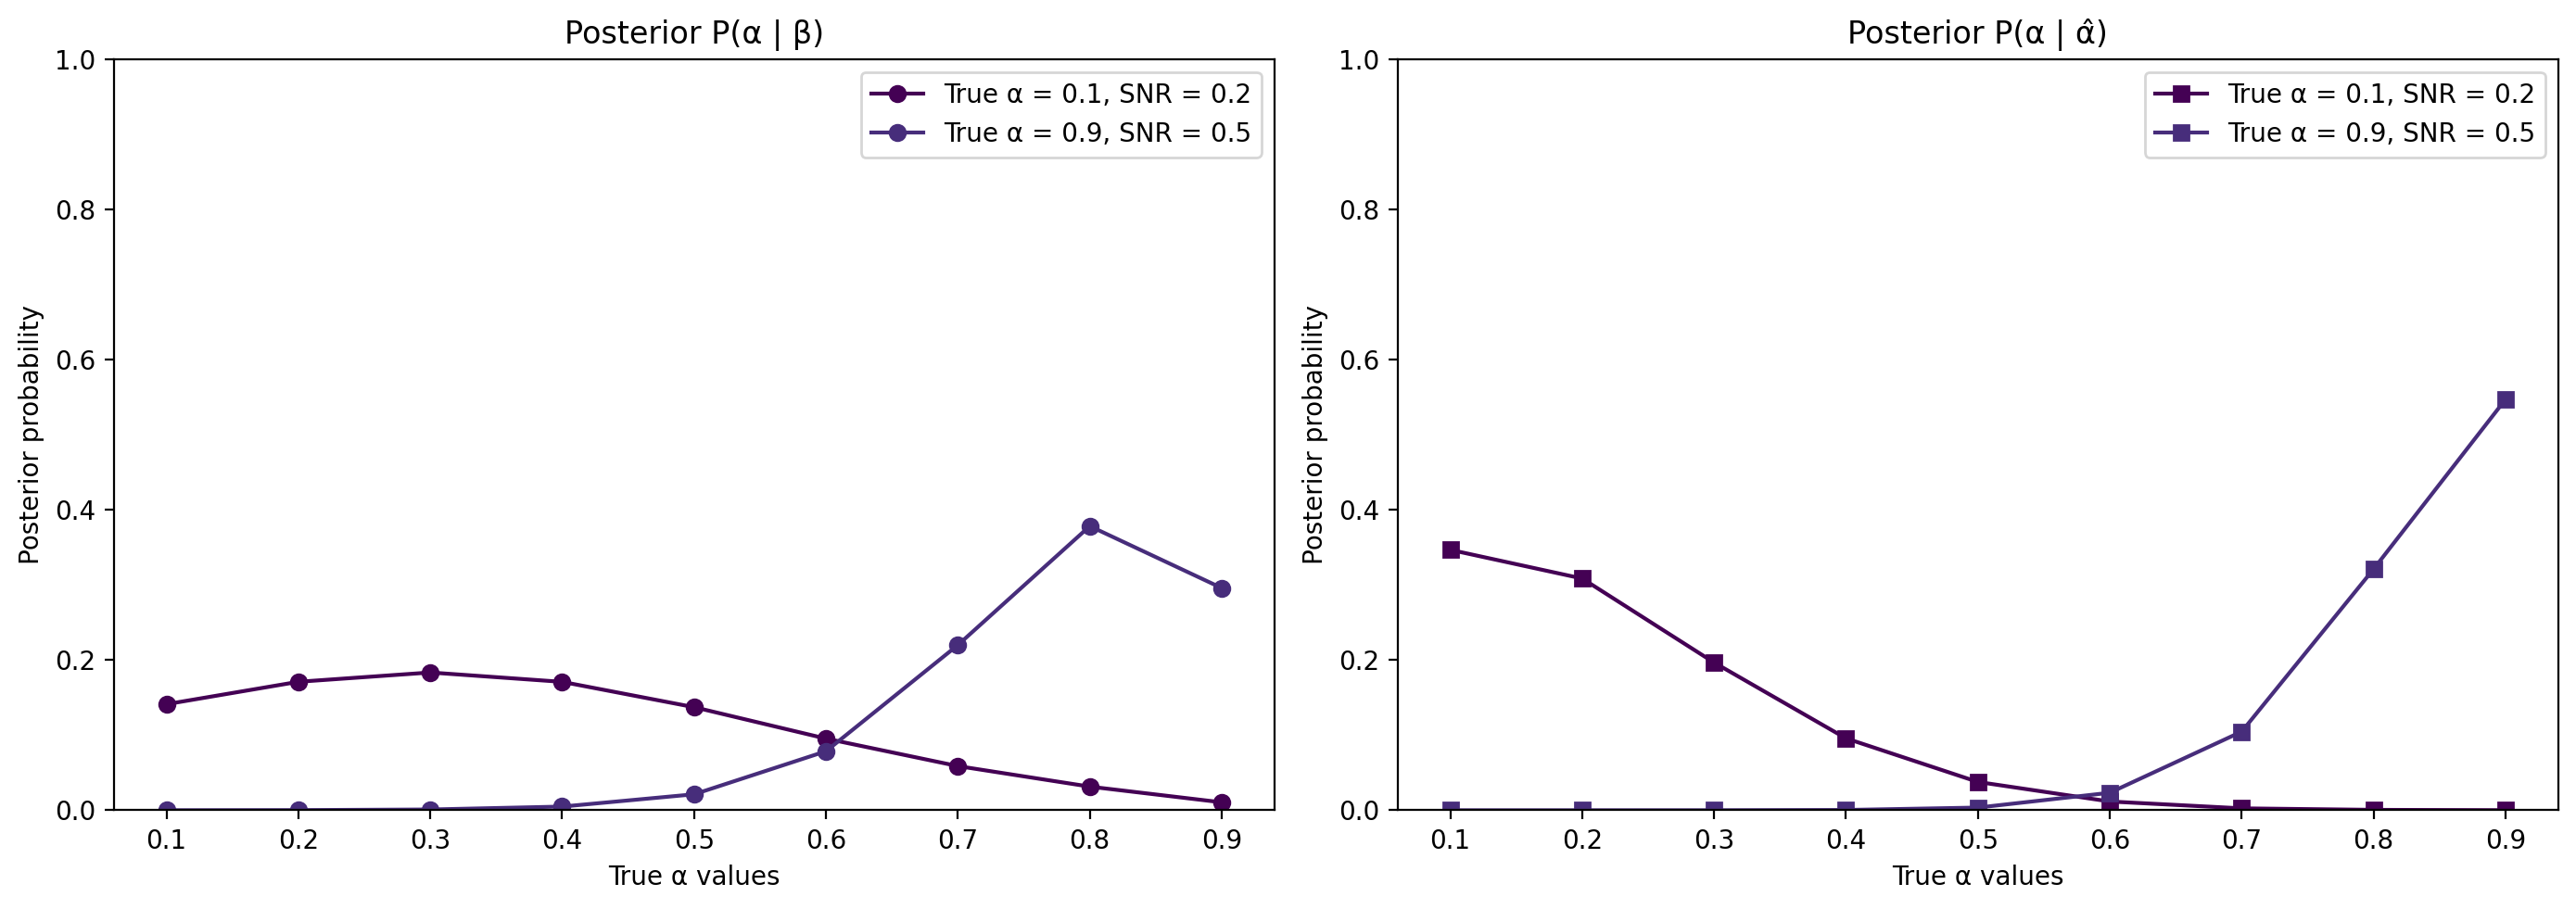

In [208]:
# --- Posterior Visualization for a few example β and α̂ values ---

# Pick a few β and α̂ values from the dataset to visualize
example_indices = [(0, 2, 5), (8, 5, 5)]  # (true alpha idx, corr idx, loop)
colors = plt.cm.viridis(np.linspace(0, 1, len(real_ar_coeff)))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (alpha_i, corr_j, loop_k) in enumerate(example_indices):
    # Get simulated β and α̂
    beta_obs = est_beta_ub[loop_k, alpha_i, corr_j]
    alpha_obs = run_avg_est_ar_coeff[loop_k, alpha_i, corr_j]

    posterior_beta = {}
    posterior_alpha = {}

    # Compute posterior P(α | β)
    for alpha in real_ar_coeff:
        alpha = float(alpha)
        log_lik = kde_by_beta[alpha].score_samples([[beta_obs]])[0]
        posterior_beta[alpha] = np.exp(log_lik) * prior_alpha[alpha]

        log_lik2 = kde_by_alpha[alpha].score_samples([[alpha_obs]])[0]
        posterior_alpha[alpha] = np.exp(log_lik2) * prior_alpha[alpha]

    # Normalize
    total_b = sum(posterior_beta.values())
    posterior_beta = {a: p/total_b for a, p in posterior_beta.items()}

    total_a = sum(posterior_alpha.values())
    posterior_alpha = {a: p/total_a for a, p in posterior_alpha.items()}

    # Plot
    axes[0].plot(real_ar_coeff, [posterior_beta[a] for a in real_ar_coeff],
                 marker='o', label=f"True α = {real_ar_coeff[alpha_i]:.1f}, SNR = {corrs[corr_j]:.1f}", color=colors[idx])
    axes[1].plot(real_ar_coeff, [posterior_alpha[a] for a in real_ar_coeff],
                 marker='s', label=f"True α = {real_ar_coeff[alpha_i]:.1f}, SNR = {corrs[corr_j]:.1f}", color=colors[idx])

axes[0].set_title("Posterior P(α | β)")
axes[1].set_title("Posterior P(α | α̂)")

for ax in axes:
    ax.set_xlabel("True α values")
    ax.set_ylabel("Posterior probability")
    ax.set_ylim(0, 1)
    ax.legend()

plt.tight_layout()

Test the decoders on new simulated data to see if they work well.

In [ ]:
# visualization bayesian
# # --- Parameters ---
nLoops = 100
nT = 100
nRuns = 10
real_ar_coeff = np.arange(0, 1, 0.1)
corrs = np.arange(0, 1, 0.1)

# --- Initialize arrays ---
sim_data = np.zeros((nLoops, len(real_ar_coeff), len(corrs), nRuns, nT))
est_beta_ub = np.zeros((nLoops, len(real_ar_coeff), len(corrs)))
run_avg_est_ar_coeff = np.zeros((nLoops, len(real_ar_coeff), len(corrs)))

alpha_true_list, alpha_pred_list, beta_pred_list, alpha_direct_list, snr_list = [], [], [], [], []

# --- Simulation + Inference Loop ---
for i, alpha in enumerate(real_ar_coeff):
    for j, corr in enumerate(corrs):
        for loop in range(nLoops):
            # Simulate time series data
            sim = make_correlated_arp(alpha, nT, n_series=nRuns, corr=corr)
            sim_data[loop, i, j] = sim

            # Estimate β (from noise)
            _, est_beta = fit_ind_noise_to_ar1(sim, nRuns)
            est_beta_ub[loop, i, j] = est_beta

            # Estimate α (direct from signal)
            avg_series = np.mean(sim, axis=0)
            zs_avg = zs(avg_series)
            ar1_model = sm.tsa.AutoReg(zs_avg, lags=1).fit()
            est_alpha = ar1_model.params[1]
            run_avg_est_ar_coeff[loop, i, j] = est_alpha

            # Predict α from estimated β using saved model
            beta_val = np.array([[est_beta]])
            beta_pred = decode_alpha_from_beta(est_beta, kde_by_beta, prior_alpha)
            alpha_pred = decode_alpha_from_beta(est_alpha, kde_by_alpha, prior_alpha)


            # Store all
            alpha_true_list.append(alpha)
            beta_pred_list.append(beta_pred)
            alpha_pred_list.append(alpha_pred)
            alpha_direct_list.append(est_alpha)
            snr_list.append(corr)

# --- Convert to arrays ---
alpha_true_array = np.array(alpha_true_list)
beta_pred_array = np.array(beta_pred_list)
alpha_pred_array = np.array(alpha_pred_list)
alpha_direct_array = np.array(alpha_direct_list)
snr_array = np.array(snr_list)

# --- Compute loop-averaged estimates per (alpha, SNR) ---
avg_beta_pred_model = np.zeros((len(real_ar_coeff), len(corrs)))
avg_alpha_pred_model = np.zeros((len(real_ar_coeff), len(corrs)))
avg_direct_est = np.zeros((len(real_ar_coeff), len(corrs)))

for i, alpha in enumerate(real_ar_coeff):
    for j, corr in enumerate(corrs):
        mask = (alpha_true_array == alpha) & (snr_array == corr)
        avg_beta_pred_model[i, j] = np.mean(beta_pred_array[mask])
        avg_alpha_pred_model[i, j] = np.mean(alpha_pred_array[mask])
        avg_direct_est[i, j] = np.mean(alpha_direct_array[mask])

# Blended prediction
min_weight = 0.1
blend_weights = np.clip(np.tile(np.linspace(1, 0, len(real_ar_coeff)), (len(corrs), 1)), min_weight, 1 - min_weight)
blended_pred_model = blend_weights * avg_beta_pred_model + (1 - blend_weights) * avg_alpha_pred_model

# # Conditional choice based on SNR threshold (e.g., 0.5)
# threshold_val = 0.5
# conditional_pred_model = np.zeros((len(real_ar_coeff), len(corrs)))
# for j, corr in enumerate(corrs):
#     for i in range(len(real_ar_coeff)):
#         if corr < threshold_val:
#             conditional_pred_model[i, j] = avg_beta_pred_model[i, j]
#         else:
#             conditional_pred_model[i, j] = avg_alpha_pred_model[i, j]


# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot direct signal-based estimates


# Plot model-based predictions (from alpha)
for i, alpha in enumerate(real_ar_coeff):
    axes[0,0].plot(corrs, avg_alpha_pred_model[i], marker='^', color='tab:blue',
                 label='Model Prediction' if i == 0 else "")
    axes[0,0].axhline(y=alpha, color='black', alpha=0.3, linestyle='--',
                    label='True α' if i == 0 else "")

axes[0,0].set(title="1) Model-Based α Prediction (from α)",
            xlabel="Correlation (SNR)", ylabel="Predicted α (from α)",
            xlim=[-0.05, 1.0], ylim=[-0.1, 1.05])
axes[0,0].legend(loc='upper left')

# Plot model-based predictions (from beta)
for i, alpha in enumerate(real_ar_coeff):
    axes[0,1].plot(corrs, avg_beta_pred_model[i], marker='^', color='tab:blue',
                 label='Model Prediction' if i == 0 else "")
    axes[0,1].axhline(y=alpha, color='black', alpha=0.3, linestyle='--',
                    label='True α' if i == 0 else "")

axes[0,1].set(title="2) Model-Based α Prediction (from β)",
            xlabel="Correlation (SNR)", ylabel="Predicted α (from β)",
            xlim=[-0.05, 1.0], ylim=[-0.1, 1.05])
axes[0,1].legend(loc='upper left')

# Subplot 2: Blended predictions
for i, alpha in enumerate(real_ar_coeff):
    axes[1, 0].plot(corrs, blended_pred_model[i], marker='x', color='tab:orange',
                    label='Blended' if i == 0 else "")
    axes[1, 0].axhline(y=alpha, color='black', alpha=0.3, linestyle='--',
                    label='True α' if i == 0 else "")
axes[1, 0].set(title="3) Blended α Prediction (weighted β & α)",
            xlabel="Correlation (SNR)", ylabel="Blended α",
            xlim=[-0.05, 1.0], ylim=[-0.1, 1.05])
axes[1, 0].legend(loc='upper left')

# Subplot 3: From fitting AR(1) to averaged data - signals
for i, alpha in enumerate(real_ar_coeff):
    axes[1,1].plot(corrs, avg_direct_est[i], marker='o', color='tab:green',
                 label='Direct Estimate' if i == 0 else "")
    axes[1,1].axhline(y=alpha, color='black', alpha=0.3, linestyle='--',
                    label='True α' if i == 0 else "")

axes[1,1].set(title="4) Direct Signal-Based Estimation (Averaged)",
            xlabel="Correlation (SNR)", ylabel="Estimated α (direct)",
            xlim=[-0.05, 1.0], ylim=[-0.1, 1.05])
axes[1,1].legend(loc='upper left')


plt.tight_layout()
plt.show()
 

KeyError: 0.0

#### Fit regression models 

0: 1.0
1: 1.0
2: 1.0
3: 0.0
4: 1.0
5: 1.0
6: 0.0
7: 0.0
8: 1.0
9: 0.0


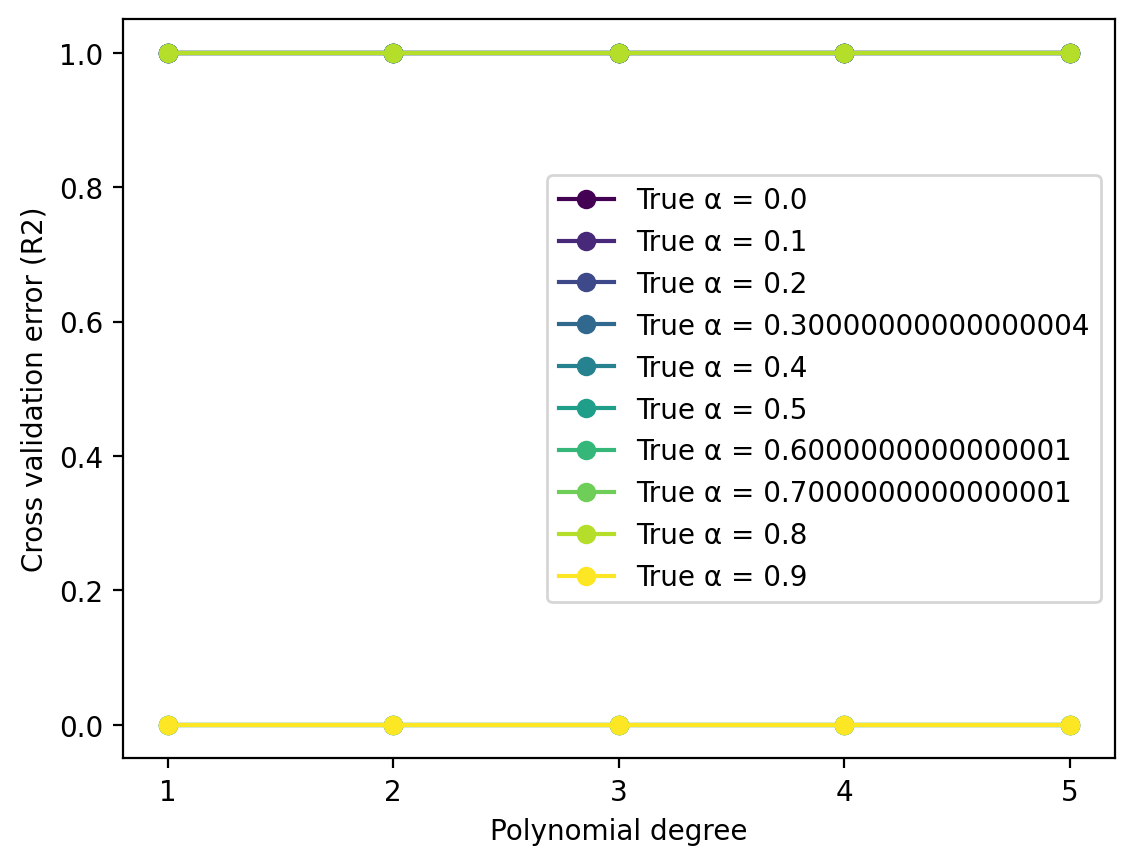

In [93]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate, KFold

colors = plt.cm.viridis(np.linspace(0, 1, len(real_ar_coeff)))

nAlphas =  len(real_ar_coeff)
nModels = 5
nFolds = 5
cv_R2 = np.zeros((nAlphas, nModels, nFolds))

for alpha in range(len(real_ar_coeff)):
    # Extract bootstrapped data
    x = est_beta_ub[:, alpha, :].reshape(-1).reshape(-1, 1)     
    # y = run_avg_est_ar_coeff[:, alpha, :].reshape(-1)
    y = np.repeat(real_ar_coeff[alpha], nLoops * len(corrs)).reshape(-1)

    for degree in range(1, nModels+1):
        to_poly = PolynomialFeatures(degree=degree, include_bias=False)
        Xpoly = to_poly.fit_transform(x)
        kf = KFold(n_splits=nFolds, shuffle=True, random_state=0)
        # cross validation
        model = LinearRegression()
        cv_results = cross_validate(model, Xpoly, y, cv=kf, scoring='r2', return_train_score=True)
        cv_R2[alpha, degree-1, :] = cv_results['test_score']

avg_cv_R2 = np.mean(cv_R2, axis=2)

degree = np.arange(1,nModels+1)
for alpha in range(len(real_ar_coeff)):
    plt.plot(degree, avg_cv_R2[alpha,:], 'o-', color=colors[alpha], label=f"True α = {real_ar_coeff[alpha]}")
    print(f"{alpha}: {avg_cv_R2[alpha,0]}")
    plt.xticks(degree)
    plt.xlabel('Polynomial degree')
    plt.ylabel('Cross validation error (R2)')
    plt.legend()


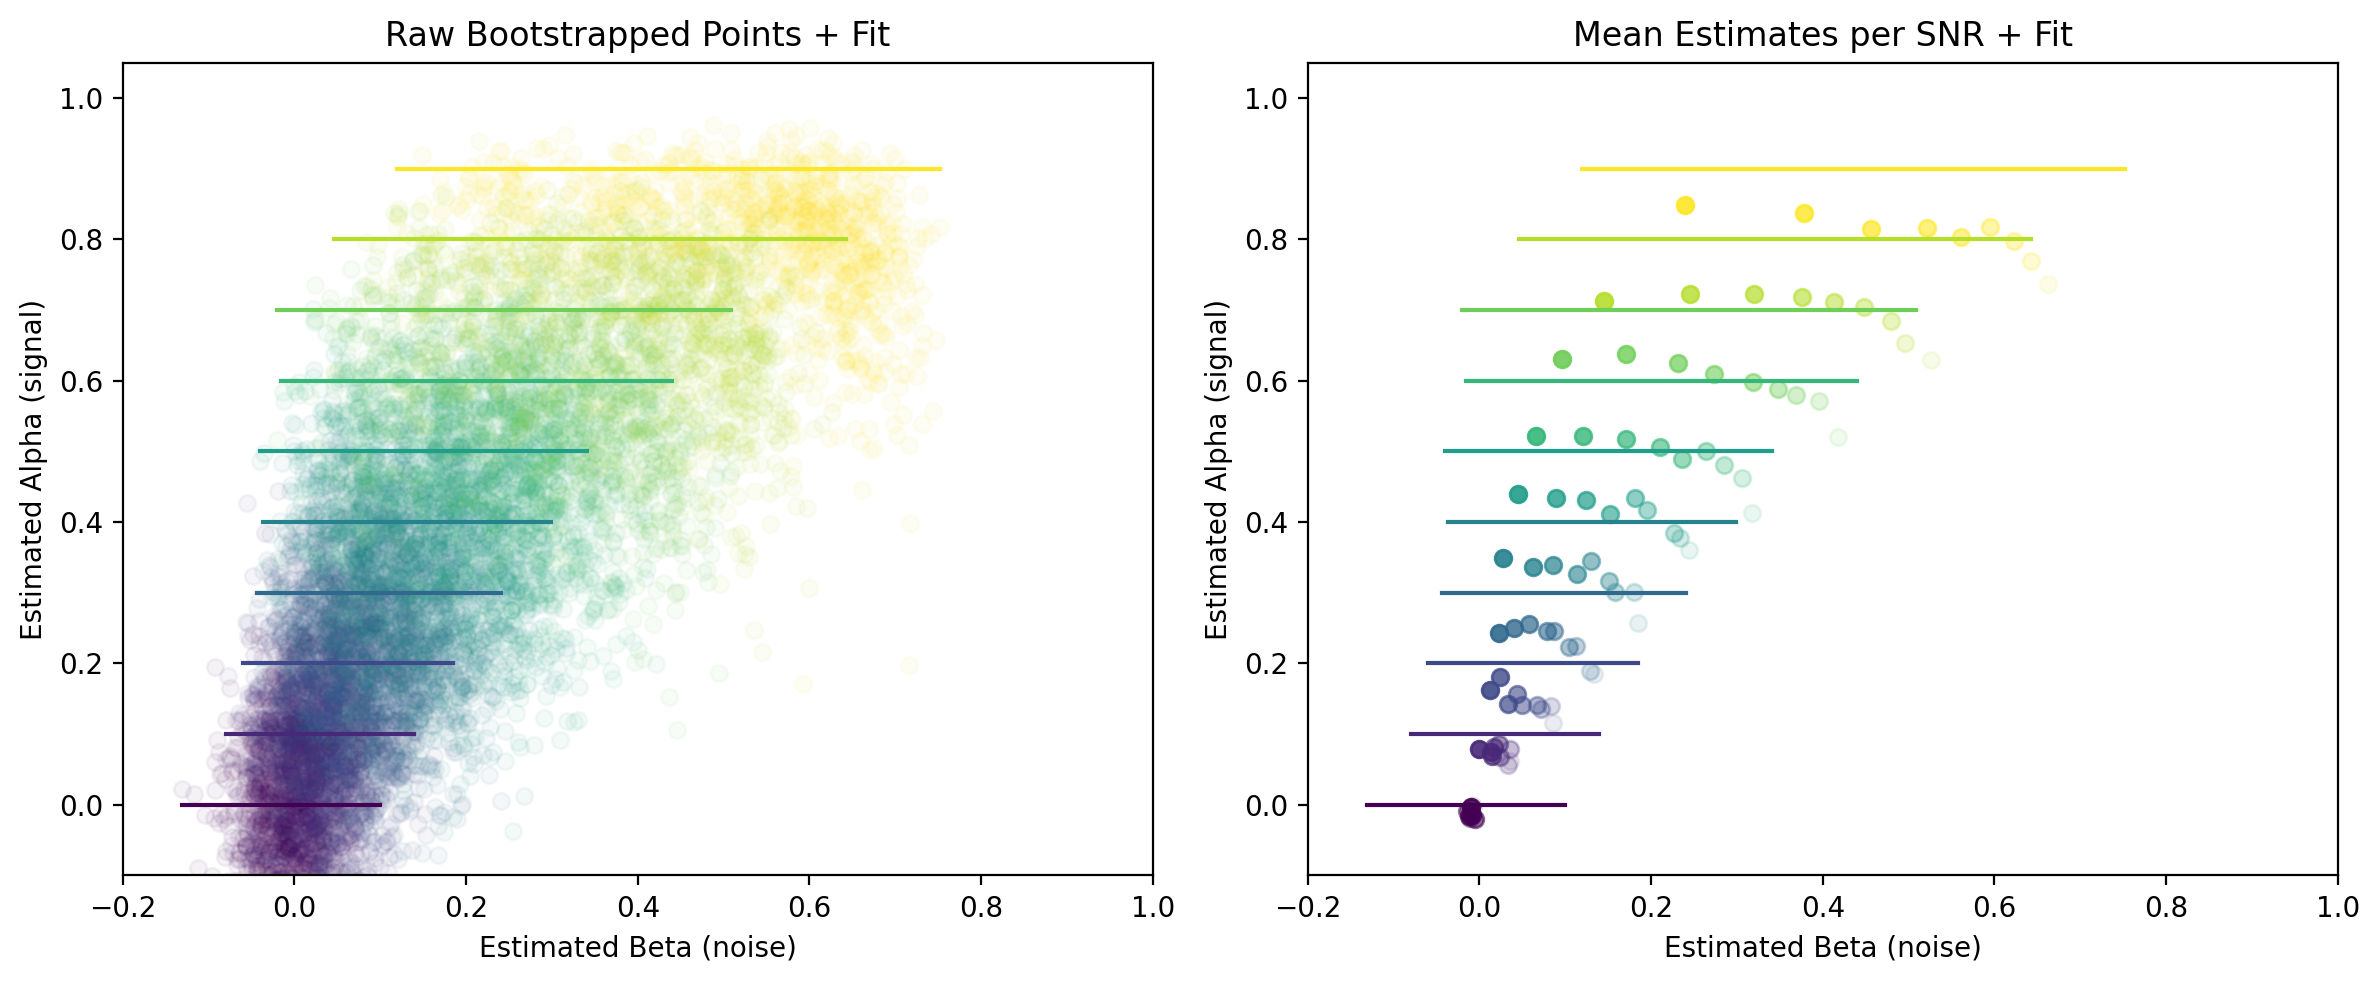

In [98]:
from sklearn.pipeline import make_pipeline
saved_models = []

for alpha in range(len(real_ar_coeff)):
    x = est_beta_ub[:, alpha, :].reshape(-1, 1)
    # y = run_avg_est_ar_coeff[:, alpha, :].reshape(-1)
    y = np.repeat(real_ar_coeff[alpha], nLoops * len(corrs)).reshape(-1)

    model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())
    model.fit(x, y)
    saved_models.append(model)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for alpha in range(len(real_ar_coeff)):
    color = colors[alpha]
    
    # Extract and fit range-specific x values
    x = est_beta_ub[:, alpha, :].reshape(-1, 1)
    x_vals = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_fit = saved_models[alpha].predict(x_vals)
    

    axes[0].plot(x_vals, y_fit, color=color, linewidth=1.5)
    axes[0].scatter(
        x,
        run_avg_est_ar_coeff[:, alpha, :].reshape(-1),
        color=color, alpha=0.05
    )
    
    axes[1].plot(x_vals, y_fit, color=color, linewidth=1.5, label=f"True α = {real_ar_coeff[alpha]}")
    for corr in range(len(corrs)):
        x_avg = avg_est_beta_ub[alpha, corr]
        y_avg = avg_est_ar_coeff[alpha, corr]
        axes[1].scatter(x_avg, y_avg, color=color, alpha=opacity[corr])


for ax in axes:
    ax.set_xlabel("Estimated Beta (noise)")
    ax.set_ylabel("Estimated Alpha (signal)")
    ax.set_xlim([-0.2, 1])
    ax.set_ylim([-0.1, 1.05])
    # ax.legend()

axes[0].set_title("Raw Bootstrapped Points + Fit")
axes[1].set_title("Mean Estimates per SNR + Fit")

plt.tight_layout()
plt.show()



Use the function learned to estimate alpha for all SNR levels using beta.

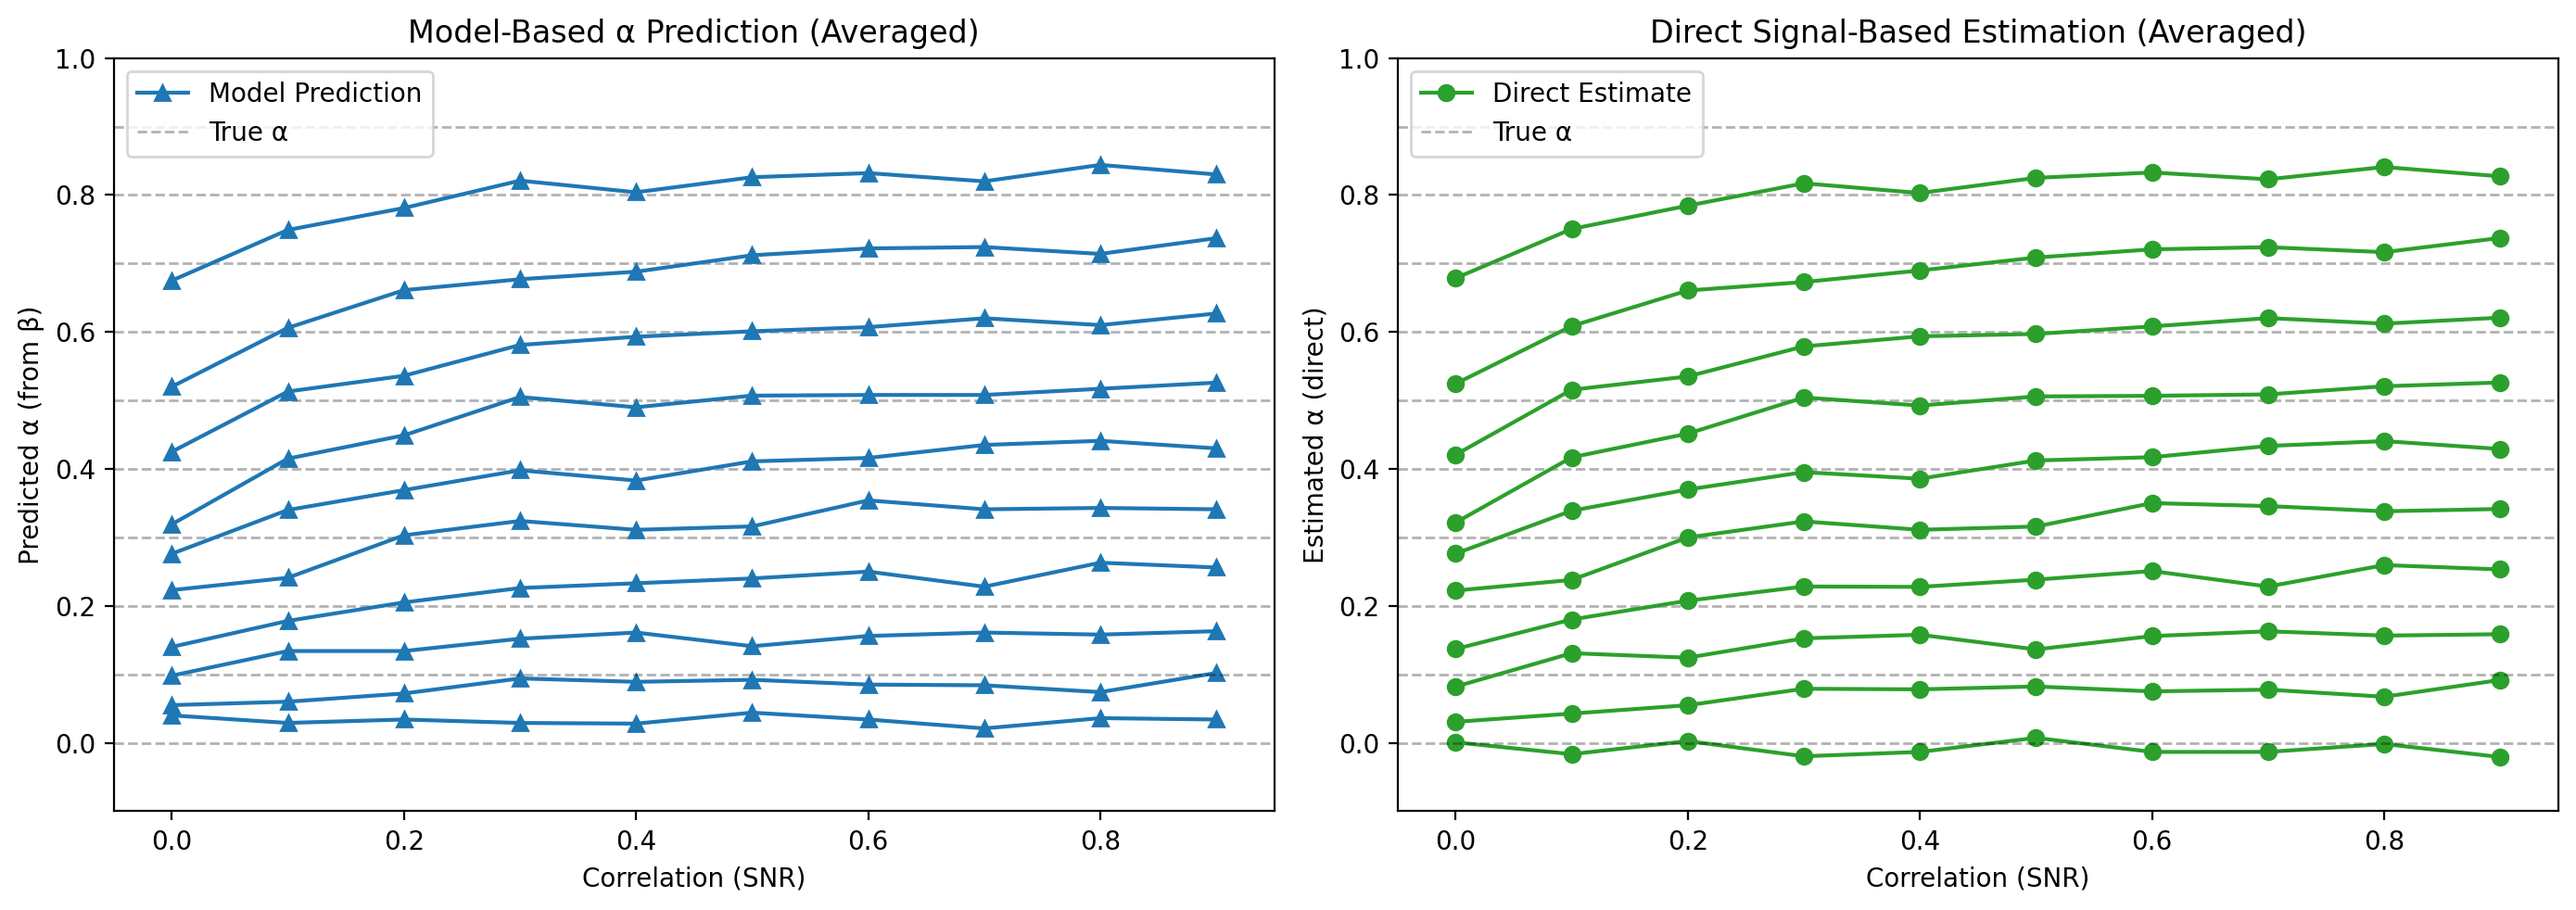

In [209]:
# --- Parameters ---
nLoops = 100
nT = 100  # number of timepoints
nRuns = 10
real_ar_coeff = np.arange(0,1,0.1)
corrs = np.arange(0, 1, 0.1)

# --- Storage Arrays ---
sim_data = np.zeros((nLoops, len(real_ar_coeff), len(corrs), nRuns, nT))
est_beta_lb = np.zeros((nLoops, len(real_ar_coeff), len(corrs)))
est_beta_ub = np.zeros((nLoops, len(real_ar_coeff), len(corrs)))
run_avg_est_ar_coeff = np.zeros((nLoops, len(real_ar_coeff), len(corrs)))

alpha_true_list = []
alpha_pred_model_list = []
alpha_direct_est_list = []
snr_list = []

# --- Simulation Loop ---
for coeff in range(len(real_ar_coeff)):
    for corr in range(len(corrs)):                
        for loop in range(nLoops):
            # Simulate new data
            sim_data[loop, coeff, corr] = make_correlated_arp(
                real_ar_coeff[coeff], nT, n_series=nRuns, corr=corrs[corr]
            )

            # Estimate AR(1) from noise (β)
            _, est_beta_ub[loop, coeff, corr] = fit_ind_noise_to_ar1(
                sim_data[loop, coeff, corr], nRuns
            )

            # Estimate AR(1) from signal (α)
            avg_series = np.mean(sim_data[loop, coeff, corr], axis=0)
            zs_avg_series = zs(avg_series)
            ar1_model = sm.tsa.AutoReg(zs_avg_series, lags=1).fit()
            est_alpha = ar1_model.params[1]
            run_avg_est_ar_coeff[loop, coeff, corr] = est_alpha

            # Ground truth and prediction
            true_alpha = real_ar_coeff[coeff]
            snr = corrs[corr]
            beta_val = est_beta_ub[loop, coeff, corr].reshape(1, -1)
            closest_alpha_idx = np.argmin(np.abs(real_ar_coeff - est_alpha))
            alpha_fit = saved_models[closest_alpha_idx].predict(beta_val)[0]
            alpha_direct = run_avg_est_ar_coeff[loop, coeff, corr]

            # Store for analysis
            alpha_true_list.append(true_alpha)
            alpha_pred_model_list.append(alpha_fit)
            alpha_direct_est_list.append(alpha_direct)
            snr_list.append(snr)

# --- Convert to Arrays ---
alpha_true_array = np.array(alpha_true_list)
alpha_pred_model_array = np.array(alpha_pred_model_list)
alpha_direct_array = np.array(alpha_direct_est_list)
snr_array = np.array(snr_list)

# --- Compute Averages Across Loops ---
avg_pred_model = np.zeros((len(real_ar_coeff), len(corrs)))
avg_direct_est = np.zeros((len(real_ar_coeff), len(corrs)))

for coeff in range(len(real_ar_coeff)):
    for corr in range(len(corrs)):
        mask = (alpha_true_array == real_ar_coeff[coeff]) & (snr_array == corrs[corr])
        avg_pred_model[coeff, corr] = np.mean(alpha_pred_model_array[mask])
        avg_direct_est[coeff, corr] = np.mean(alpha_direct_array[mask])

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Model-Based α Prediction
for coeff in range(len(real_ar_coeff)):
    axes[0].plot(
        corrs, avg_pred_model[coeff],
        marker='^', color='tab:blue',
        label='Model Prediction' if coeff == 0 else ""
    )
    axes[0].axhline(
        y=real_ar_coeff[coeff],
        color='black', alpha=0.3, linewidth=1, linestyle='--',
        label='True α' if coeff == 0 else ""
    )

axes[0].set_ylim([-0.1, 1])
axes[0].set_xlim([min(corrs) - 0.05, max(corrs) + 0.05])
axes[0].set_xlabel("Correlation (SNR)")
axes[0].set_ylabel("Predicted α (from β)")
axes[0].set_title("Model-Based α Prediction (Averaged)")
axes[0].legend(loc='upper left')

# Subplot 2: Direct Signal-Based Estimation
for coeff in range(len(real_ar_coeff)):
    axes[1].plot(
        corrs, avg_direct_est[coeff],
        marker='o', color='tab:green',
        label='Direct Estimate' if coeff == 0 else ""
    )
    axes[1].axhline(
        y=real_ar_coeff[coeff],
        color='black', alpha=0.3, linewidth=1, linestyle='--',
        label='True α' if coeff == 0 else ""
    )

axes[1].set_ylim([-0.1, 1])
axes[1].set_xlim([min(corrs) - 0.05, max(corrs) + 0.05])
axes[1].set_xlabel("Correlation (SNR)")
axes[1].set_ylabel("Estimated α (direct)")
axes[1].set_title("Direct Signal-Based Estimation (Averaged)")
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()


The noise AR(1) coeff estimation works pretty well too. 
- simply adding beta estimates to alpha estimates from fitting AR(1) does not work. Try simulating the relationship between alpha and beta estimates and apply correction that way. 


Next, fit the same ARMA(2,1) model to the simulated data with different SNR, and see how accurately the model can estimate the ground truth alphas that are used to generate data. 

Here, I tried two different approaches:
1. fit data to ARMA(2,1) and calculate alpha and beta directly
2. fit data to ARMA(2,1), fit noise to AR(1), get beta estimate first, and calculating alpha based on the beta estimate

In [198]:
##### Assuming stationarity met #######
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, yule_walker
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")


def initialize_arma_params(series):
    # AR(2) coeff 
    phi_init, _ = yule_walker(series, order=2)
    # MA(1) coeff
    acf_values = acf(series, nlags=1)
    theta_init = -acf_values[1]
    
    return [phi_init[0], phi_init[1], theta_init]

nLoops = 100
nT = 100  # number of timepoints
nRuns = 10
true_alpha = np.array([0.1, 0.5, 0.9])
corrs = np.arange(0, 1, 0.1)
sim_data = np.zeros((nLoops, len(true_alpha), len(corrs), nRuns, nT))

num_failures = 0
non_stationary_count = 0
alpha_recovered = np.zeros((nLoops, len(true_alpha), len(corrs)))
beta_recovered1 = np.zeros((nLoops, len(true_alpha), len(corrs)))
beta_recovered2 = np.zeros((nLoops, len(true_alpha), len(corrs)))
phi_1_recovered = np.zeros((nLoops, len(true_alpha), len(corrs)))
phi_2_recovered = np.zeros((nLoops, len(true_alpha), len(corrs)))
theta_recovered = np.zeros((nLoops, len(true_alpha), len(corrs)))

est_beta_lb = np.zeros((nLoops, len(true_alpha), len(corrs)))
est_beta_ub = np.zeros((nLoops, len(true_alpha), len(corrs)))

alpha_ar1 = np.zeros((nLoops, len(true_alpha), len(corrs)))

small_eps = 1e-6  # Avoid division by zero

for loop in range(nLoops):
    for coeff in range(len(true_alpha)):
        for corr in range(len(corrs)):
            # Generate correlated ARP data
            sim_data[loop, coeff, corr, :, :] = make_correlated_arp(
                true_alpha[coeff], nT, n_series=nRuns, corr=corrs[corr]
            )
            # Fit AR(1) to noise
            est_beta_lb[loop, coeff, corr], est_beta_ub[loop, coeff, corr] = fit_ind_noise_to_ar1(sim_data[loop, coeff, corr, :, :], nRuns)

            # Average across 10 runs 
            avg_series = np.mean(sim_data[loop, coeff, corr, :, :], axis=0)
            zs_avg_series = zs(avg_series)
            
            # Fit AR(1) to run average
            ar1_model = sm.tsa.AutoReg((zs_avg_series), lags=1).fit()
            alpha_ar1[loop, coeff, corr] = ar1_model.params[1]

            # Fit ARMA(2,1) to run average
            try:
                model = SARIMAX(
                    zs_avg_series, order=(2, 0, 1), trend='n',
                    enforce_stationarity=True, enforce_invertibility=True
                )

                init_params = model.start_params
                # arma_result = model.fit(start_params=[0.3, -0.1, 0.1, 1.0], method='powell', maxiter=500, disp=False)
                #arma_result = model.fit(start_params=init_params, method='lbfgs', disp=False)
                arma_result = model.fit(start_params=init_params, method='powell', maxiter=500, disp=False)


                # Check if optimization converged
                if not arma_result.mle_retvals.get('converged', False):
                    num_failures += 1
                    print(f"Warning: Fit failed on loop {loop}, coeff {coeff}, corr {corr}.")
                    continue

                # Extract estimated parameters
                phi_1, phi_2, theta = arma_result.params[:3]

                # Check stationarity conditions for AR(2) process
                D = phi_1**2 + 4 * phi_2
                if D <= 0 or (phi_1 + phi_2 >= 1) or (phi_2 - phi_1 >= 1):
                    num_failures += 1
                    continue  # Skip iteration if conditions are not met

                # Compute recovered AR(1) coefficients
                alpha_recovered[loop, coeff, corr] = (phi_1 + np.sqrt(D)) / 2
                beta_recovered1[loop, coeff, corr] = phi_2 / (-alpha_recovered[loop, coeff, corr] + small_eps)
                beta_recovered2[loop, coeff, corr] = phi_1 - alpha_recovered[loop, coeff, corr]
                phi_1_recovered[loop, coeff, corr] = phi_1
                phi_2_recovered[loop, coeff, corr] = phi_2 
                theta_recovered[loop, coeff, corr] = theta

            except Exception as e:
                num_failures += 1
                print(f"Error in loop {loop}, coeff {coeff}, corr {corr}: {e}")

failure_rate = (num_failures / (nLoops * len(true_alpha) * len(corrs))) * 100
print(f"Total failed optimizations: {num_failures}/{nLoops * len(true_alpha) * len(corrs)} ({failure_rate:.2f}%)")


Total failed optimizations: 679/3000 (22.63%)


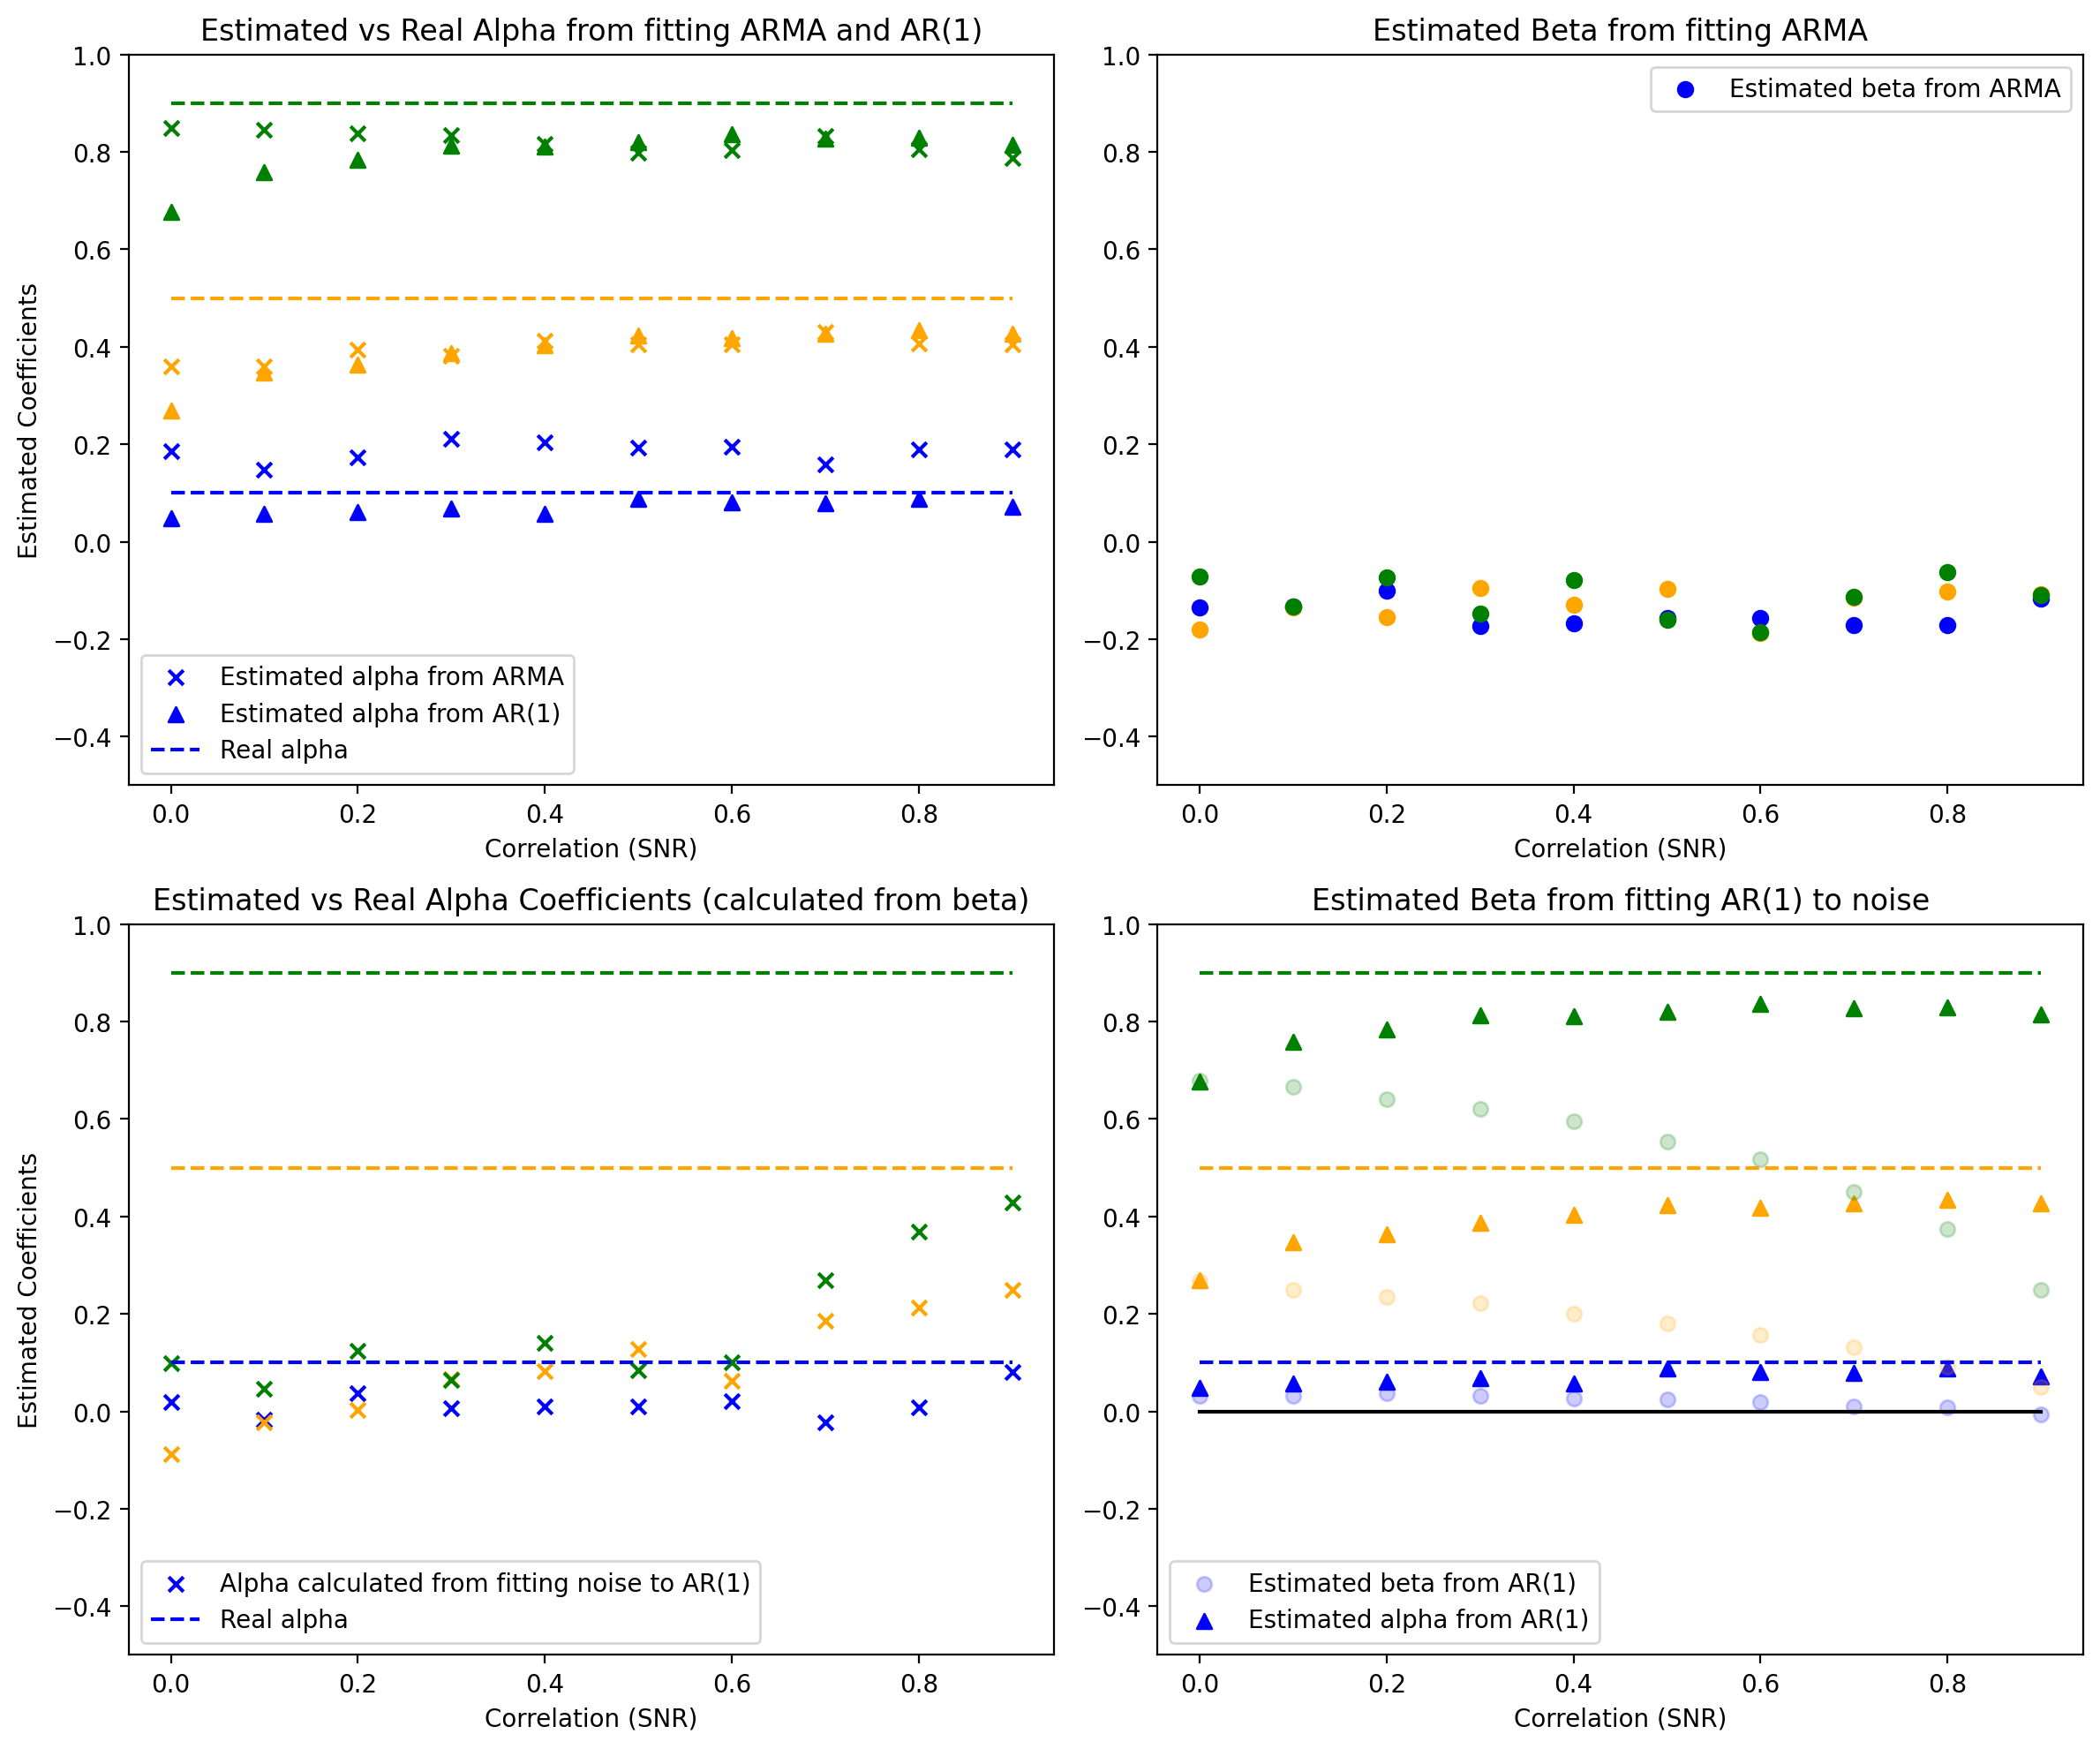

In [215]:
# Plotting 
# Compute mean values across loops
avg_alpha_ar1 = np.mean(alpha_ar1, axis=0)
# estimating alpha and beta directly from ARMA fits
avg_alpha_recovered = np.mean(alpha_recovered, axis=0)
avg_beta_recovered = np.mean((beta_recovered1 + beta_recovered2) / 2, axis=0)  # Average of beta estimates
# fitting AR(1) to noise and calculate alpha           
avg_beta_fitted = np.mean(est_beta_ub, axis=0)
alpha_calculated =  np.mean(phi_1_recovered, axis=0) - avg_beta_fitted
# alpha_calculated = -np.mean(phi_2_recovered, axis=0)/avg_beta_fitted

# Define colors for different true alpha values
colors = ['blue', 'orange', 'green']

# Create figure with two subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot estimated alpha values
for coeff in range(len(true_alpha)):
    axes[0].scatter(corrs, avg_alpha_recovered[coeff, :], color=colors[coeff], marker='x',
                    label=f'Estimated alpha from ARMA' if coeff == 0 else "")
    axes[0].scatter(corrs, avg_alpha_ar1[coeff,:], color=colors[coeff], marker='^',
                    label=f'Estimated alpha from AR(1)' if coeff == 0 else "")
    axes[0].plot(corrs, [true_alpha[coeff]] * len(corrs), color=colors[coeff], linestyle='--',
                 label=f'Real alpha' if coeff == 0 else "")

# Labels and legend for alpha plot
axes[0].set_xlabel("Correlation (SNR)")
axes[0].set_ylabel("Estimated Coefficients")
axes[0].set_title("Estimated vs Real Alpha from fitting ARMA and AR(1)")
axes[0].set_ylim([-0.5,1])
axes[0].legend()

# Plot estimated beta values
for coeff in range(len(true_alpha)):
    axes[1].scatter(corrs, avg_beta_recovered[coeff, :], color=colors[coeff], marker='o',
                    label=f'Estimated beta from ARMA' if coeff == 0 else "")

# Labels and legend for beta plot
axes[1].set_xlabel("Correlation (SNR)")
axes[1].set_title("Estimated Beta from fitting ARMA")
axes[1].set_ylim([-0.5,1])
axes[1].legend()

for coeff in range(len(true_alpha)):
    axes[2].scatter(corrs, alpha_calculated[coeff, :], color=colors[coeff], marker='x',
                    label=f'Alpha calculated from fitting noise to AR(1)' if coeff == 0 else "")
    axes[2].plot(corrs, [true_alpha[coeff]] * len(corrs), color=colors[coeff], linestyle='--',
                 label=f'Real alpha' if coeff == 0 else "")

# Labels and legend for alpha plot
axes[2].set_xlabel("Correlation (SNR)")
axes[2].set_ylabel("Estimated Coefficients")
axes[2].set_title("Estimated vs Real Alpha Coefficients (calculated from beta)")
axes[2].set_ylim([-0.5,1])
axes[2].legend()

# Plot estimated beta values
for coeff in range(len(true_alpha)):
    axes[3].scatter(corrs, avg_beta_fitted[coeff, :], color=colors[coeff], marker='o', alpha=0.2,
                    label=f'Estimated beta from AR(1)' if coeff == 0 else "")
    axes[3].scatter(corrs, avg_alpha_ar1[coeff,:], color=colors[coeff], marker='^',
                    label=f'Estimated alpha from AR(1)' if coeff == 0 else "")
    axes[3].plot(corrs, [true_alpha[coeff]] * len(corrs), color=colors[coeff], linestyle='--')
# axes[3].plot(corrs, [0] * len(corrs), color='k', linestyle='-')
# Labels and legend for beta plot
axes[3].set_xlabel("Correlation (SNR)")
axes[3].set_title("Estimated Beta from fitting AR(1) to noise")
axes[3].set_ylim([-0.5,1])
axes[3].legend()

plt.tight_layout()
plt.show()


Neither worked super well. Try something else. 

Total failed optimizations: 46/3000 (1.53%)


Text(0, 0.5, 'Estimated AR(1) coefficient')

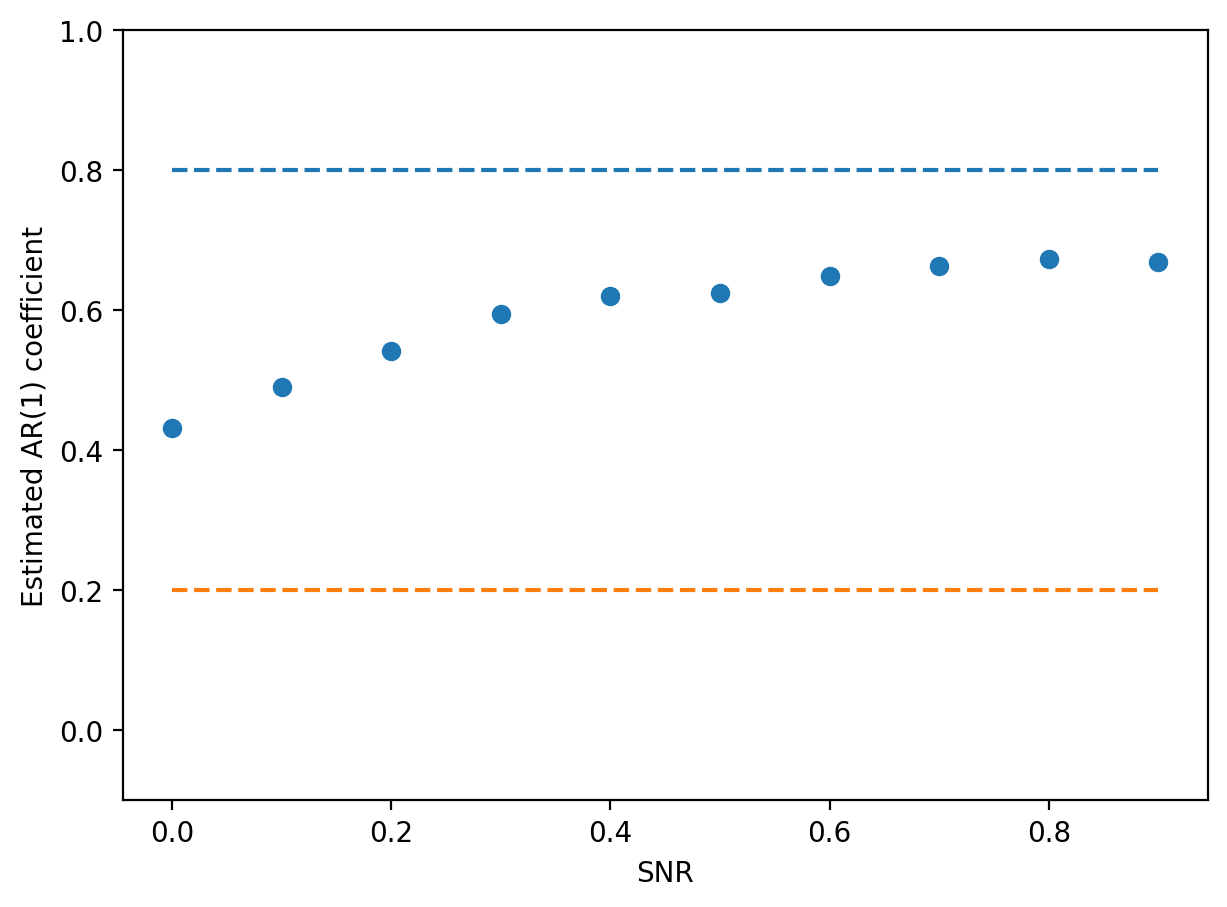

In [258]:
nLoops = 100
alpha = 0.8
beta = 0.2
nT = 100
nRuns = 10
signal_corrs = np.arange(0,1,0.1) 
noise_corr = 0.3
noisy_signals = np.zeros((nLoops, len(signal_corrs), nRuns, nT))
ar1_coeff = np.zeros((nLoops, len(signal_corrs)))

num_failures = 0
non_stationary_count = 0
alpha_recovered = np.zeros((nLoops, len(corrs)))
beta_recovered1 = np.zeros((nLoops, len(corrs)))
beta_recovered2 = np.zeros((nLoops, len(corrs)))
phi_1_recovered = np.zeros((nLoops, len(corrs)))
phi_2_recovered = np.zeros((nLoops, len(corrs)))
theta_recovered = np.zeros((nLoops, len(corrs)))

for loop in range(nLoops):
    for corr in range(len(signal_corrs)):
        _, _, noisy_signals[loop, corr] = make_ar1s(alpha, beta, nT, signal_corrs[corr], noise_corr)
        avg_series = np.mean(noisy_signals[loop, corr, :, :], axis=0)
        zs_avg_series = zs(avg_series)  

        # Fit AR(1) to run average
        ar1_model = sm.tsa.AutoReg(zs_avg_series, lags=1).fit()
        ar1_coeff[loop, corr] = ar1_model.params[1]

        # Fit ARMA(2,1) to run average
        try:
            model = SARIMAX(
                zs_avg_series, order=(2, 0, 1), trend='n',
                enforce_stationarity=True, enforce_invertibility=True
                )

            init_params = model.start_params
            arma_result = model.fit(start_params=init_params, method='powell', maxiter=500, disp=False)

            # Check if optimization converged
            if not arma_result.mle_retvals.get('converged', False):
                num_failures += 1
                print(f"Warning: Fit failed on loop {loop}, corr {corr}.")
                continue

            # Extract estimated parameters
            phi_1, phi_2, theta = arma_result.params[:3]

            # Check stationarity conditions for AR(2) process
            D = phi_1**2 + 4 * phi_2
            if D <= 0 or (phi_1 + phi_2 >= 1) or (phi_2 - phi_1 >= 1):
                num_failures += 1
                continue  # Skip iteration if conditions are not met

            # Compute recovered AR(1) coefficients
            alpha_recovered[loop, corr] = (phi_1 + np.sqrt(D)) / 2
            beta_recovered1[loop, corr] = phi_2 / (-alpha_recovered[loop, corr] + small_eps)
            beta_recovered2[loop, corr] = phi_1 - alpha_recovered[loop, corr]
            phi_1_recovered[loop, corr] = phi_1
            phi_2_recovered[loop, corr] = phi_2 
            theta_recovered[loop, corr] = theta

        except Exception as e:
            num_failures += 1
            print(f"Error in loop {loop}, corr {corr}: {e}")

failure_rate = (num_failures / (nLoops * len(true_alpha) * len(corrs))) * 100
print(f"Total failed optimizations: {num_failures}/{nLoops * len(true_alpha) * len(corrs)} ({failure_rate:.2f}%)")


# plotting
avg_ar_coeff = np.mean(ar1_coeff, axis=0)
plt.figure(figsize=(7,5))
plt.scatter(signal_corrs, avg_ar_coeff, label='AR(1) coefficient estimates')
plt.plot(signal_corrs, [alpha] * len(signal_corrs), label="Real alpha", linestyle='--')
plt.plot(signal_corrs, [beta] * len(signal_corrs), label="Real beta", linestyle='--')
plt.ylim([-0.1, 1])
plt.xlabel('SNR')
plt.ylabel('Estimated AR(1) coefficient')


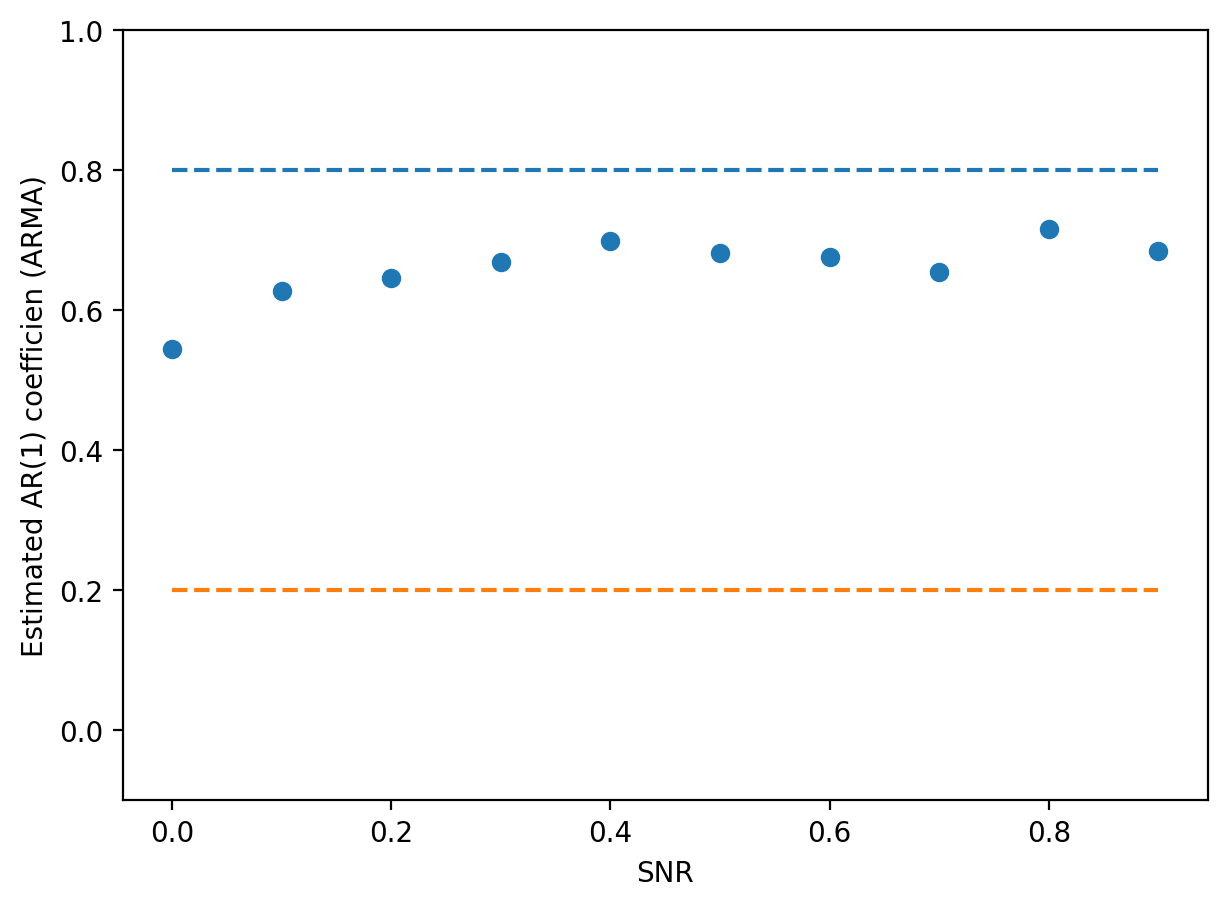

In [260]:
# plotting
avg_alpha_recovered = np.mean(alpha_recovered, axis=0)
plt.figure(figsize=(7,5))
plt.scatter(signal_corrs, avg_alpha_recovered, label='AR(1) coefficient estimates')
plt.plot(signal_corrs, [alpha] * len(signal_corrs), label="Real alpha", linestyle='--')
plt.plot(signal_corrs, [beta] * len(signal_corrs), label="Real beta", linestyle='--')
plt.ylim([-0.1, 1])
plt.xlabel('SNR')
plt.ylabel('Estimated AR(1) coefficien (ARMA)')
plt.show()

#### Plot time series data to see if there'd be any trend or seasonality. 
- there shouldn't be any the way I'm simulating data, but good to check the real data anyways. 

In [112]:
import statsmodels.tsa.stattools as smt
from scipy.fft import fft

def analyze_time_series(time_series, sampling_rate=1, max_lag=100):
    """
    Performs FFT, ACF, and ADF test to analyze seasonality, trend, and stationarity in a time series.
    """

    time_series = np.array(time_series).flatten()

    # Visualize raw data
    plt.figure(figsize=(10, 3))
    # plt.plot(time_series, label=f"Raw data (alpha = {true_alpha})")
    plt.plot(time_series, label="Raw data")


    plt.xlabel('Time')
    plt.title("Visualize the raw time series data")
    plt.legend()
    plt.show()

    # Compute FFT for seasonality detection
    fft_values = np.abs(fft(time_series))
    freqs = np.fft.fftfreq(len(time_series), d=sampling_rate)

    plt.figure(figsize=(10, 3))
    plt.plot(freqs[freqs > 0], fft_values[freqs > 0], label="FFT Magnitude")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.title("Fourier Transform (FFT) for Seasonality Detection")
    plt.legend()
    plt.show()

    # Compute and plot ACF
    acf_values = smt.acf(time_series, nlags=max_lag)
    
    plt.figure(figsize=(10, 3))
    plt.bar(range(len(acf_values)), acf_values, width=0.8, label="ACF")
    plt.xlabel("Lags")
    plt.ylabel("Autocorrelation")
    plt.title("Autocorrelation Function (ACF) for Periodicity Detection")
    plt.axhline(y=0, linestyle="--", color='red', alpha=0.6)
    plt.legend()
    plt.show()

    # ADF Test for Stationarity
    adf_result = smt.adfuller(time_series)
    p_value = adf_result[1]
    print(f"p-value: {p_value:.4f}")

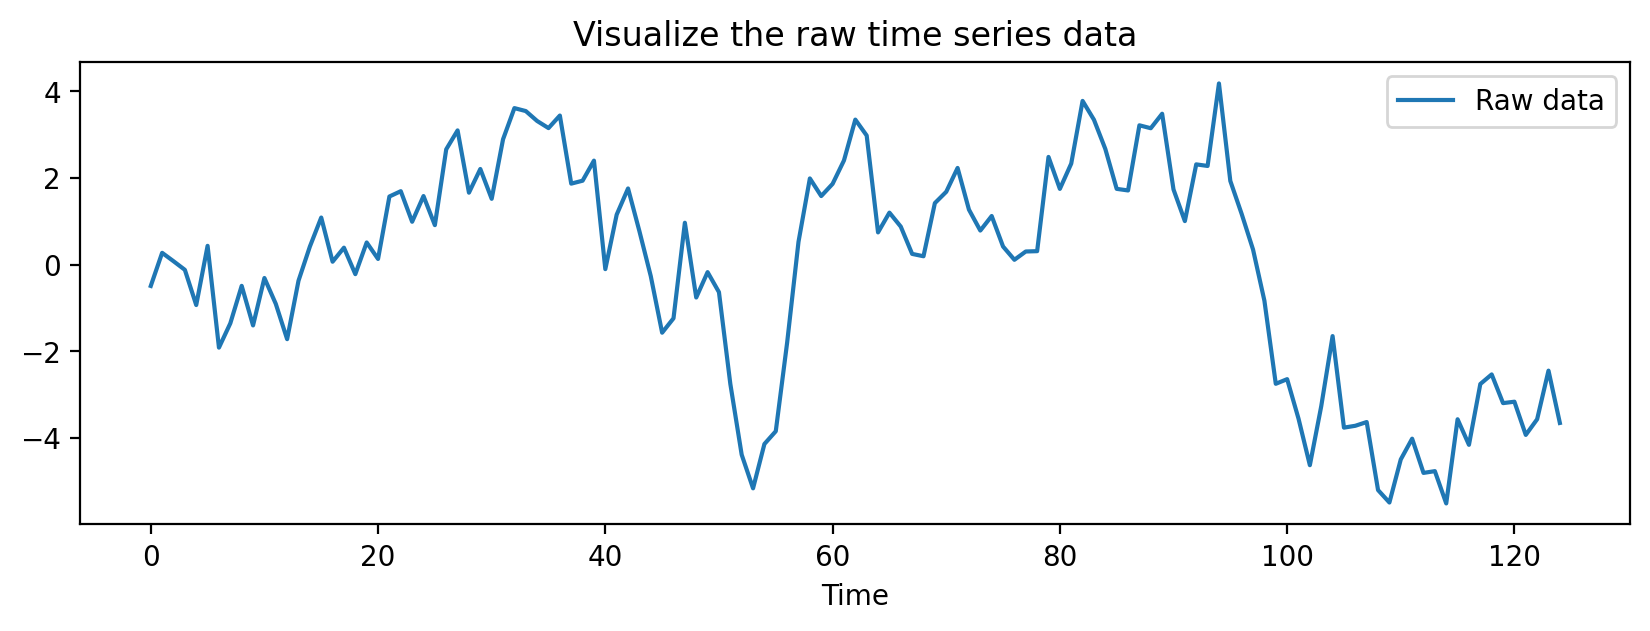

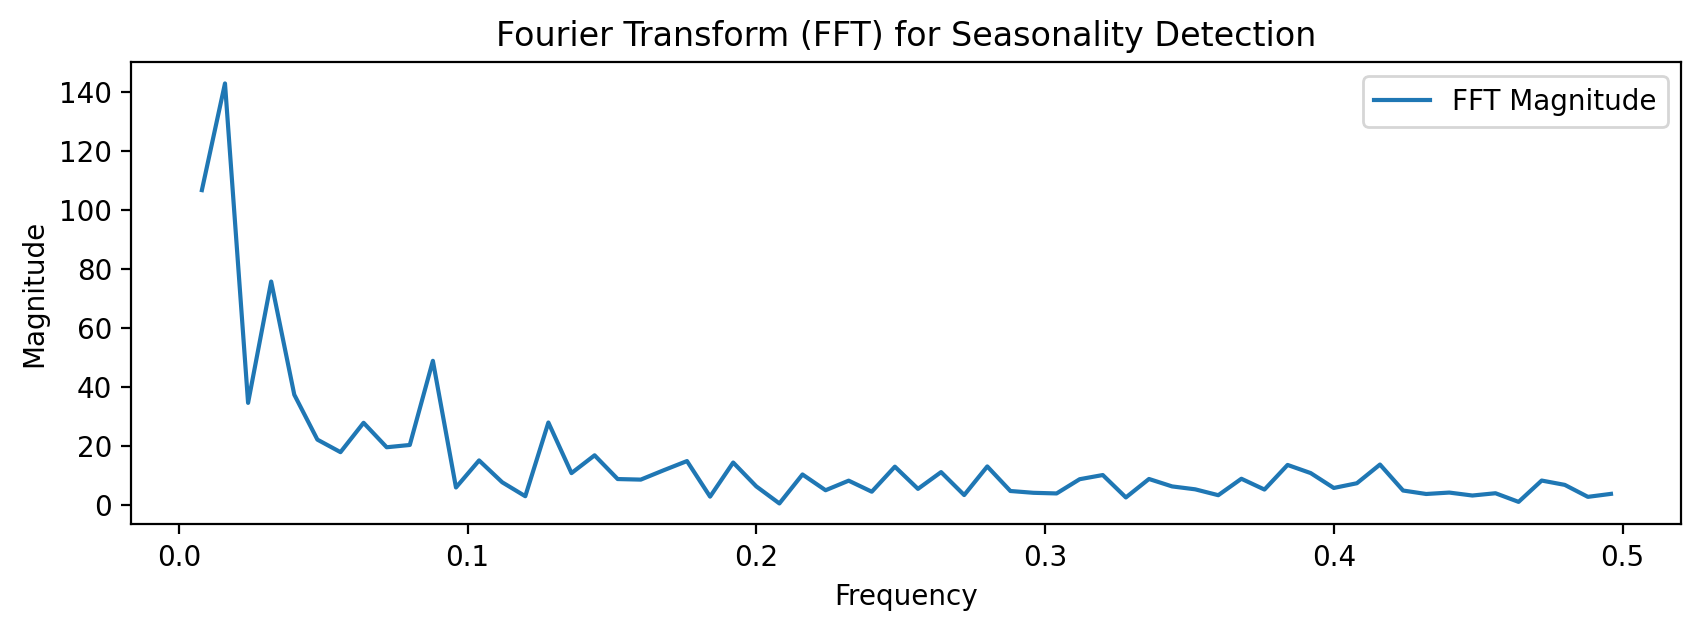

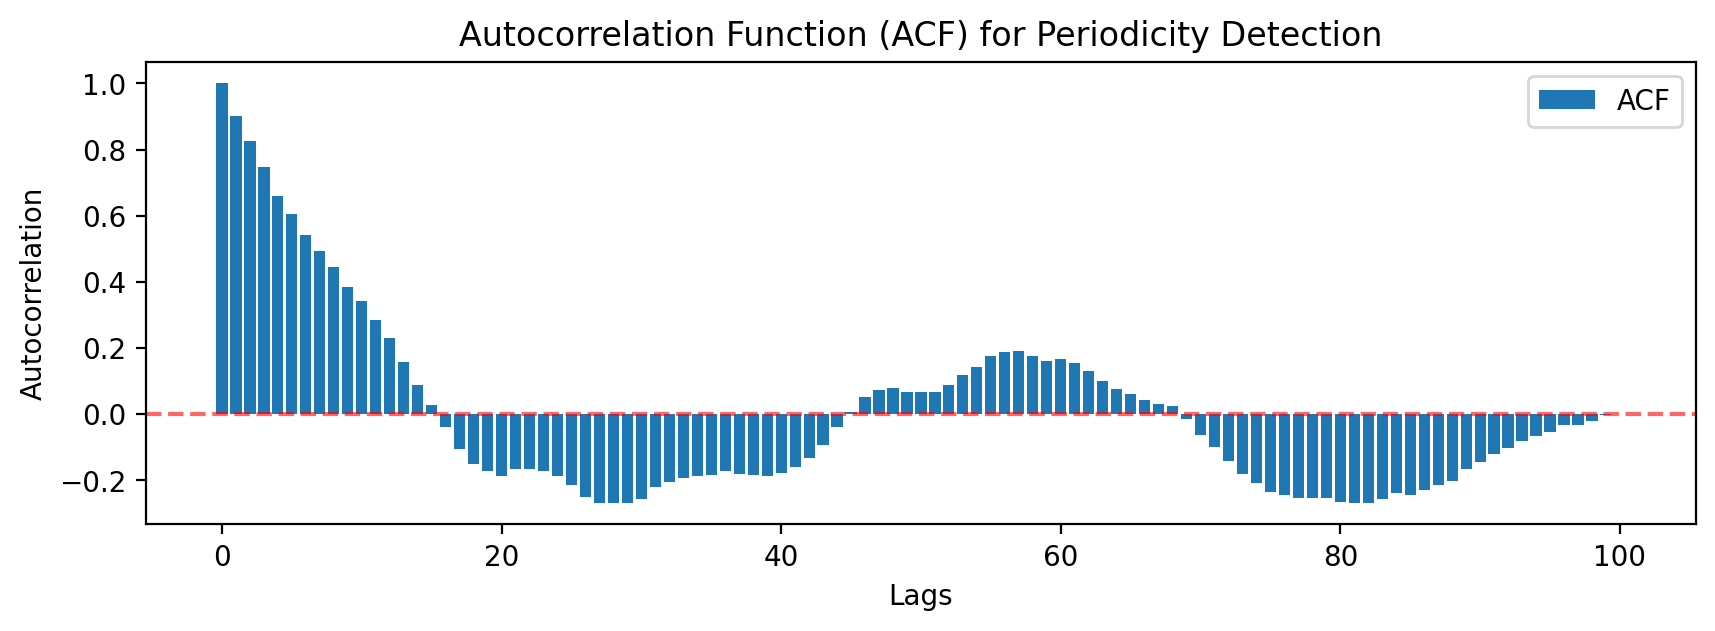

p-value: 0.2078


In [132]:
true_alpha = 0.9
corr = 1
nT = 125
nRuns = 1
sim_data = make_correlated_arp(
                true_alpha, nT, n_series=nRuns, corr=corr
            )
analyze_time_series(sim_data)

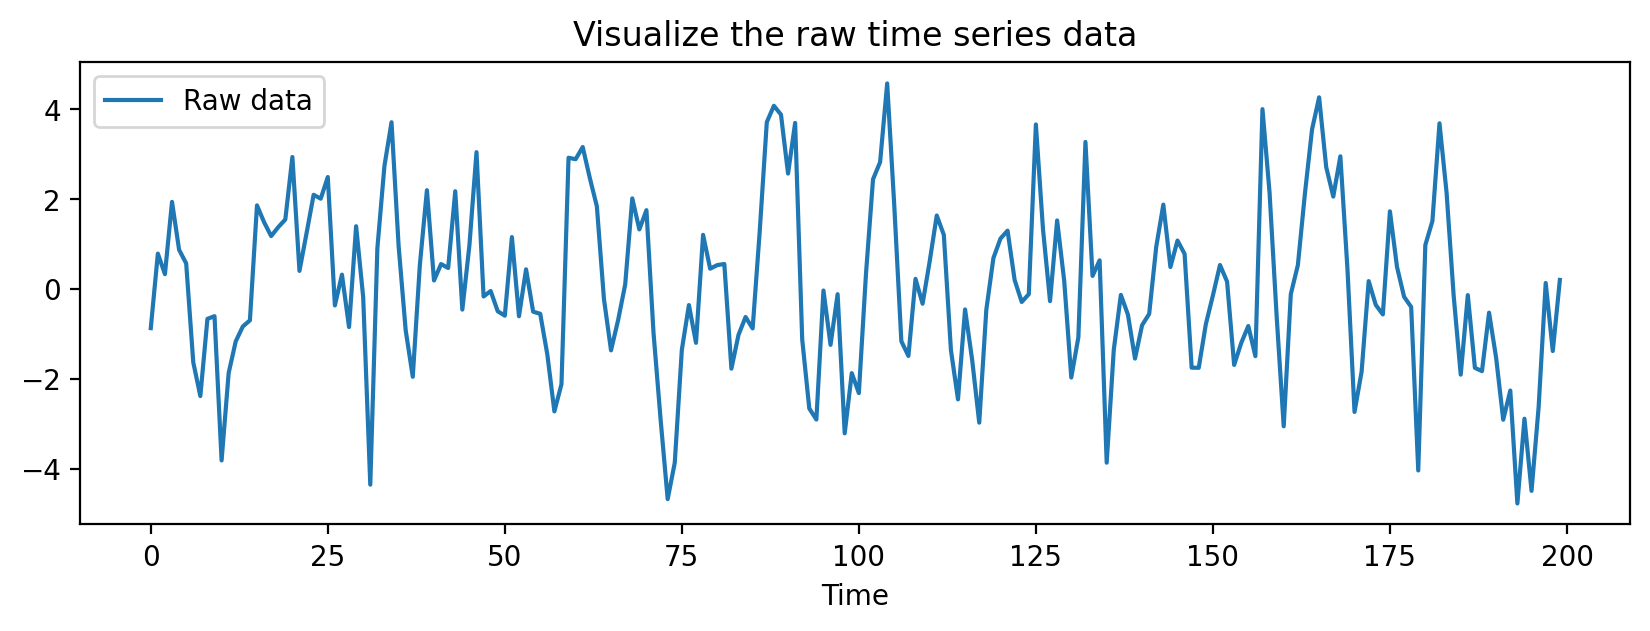

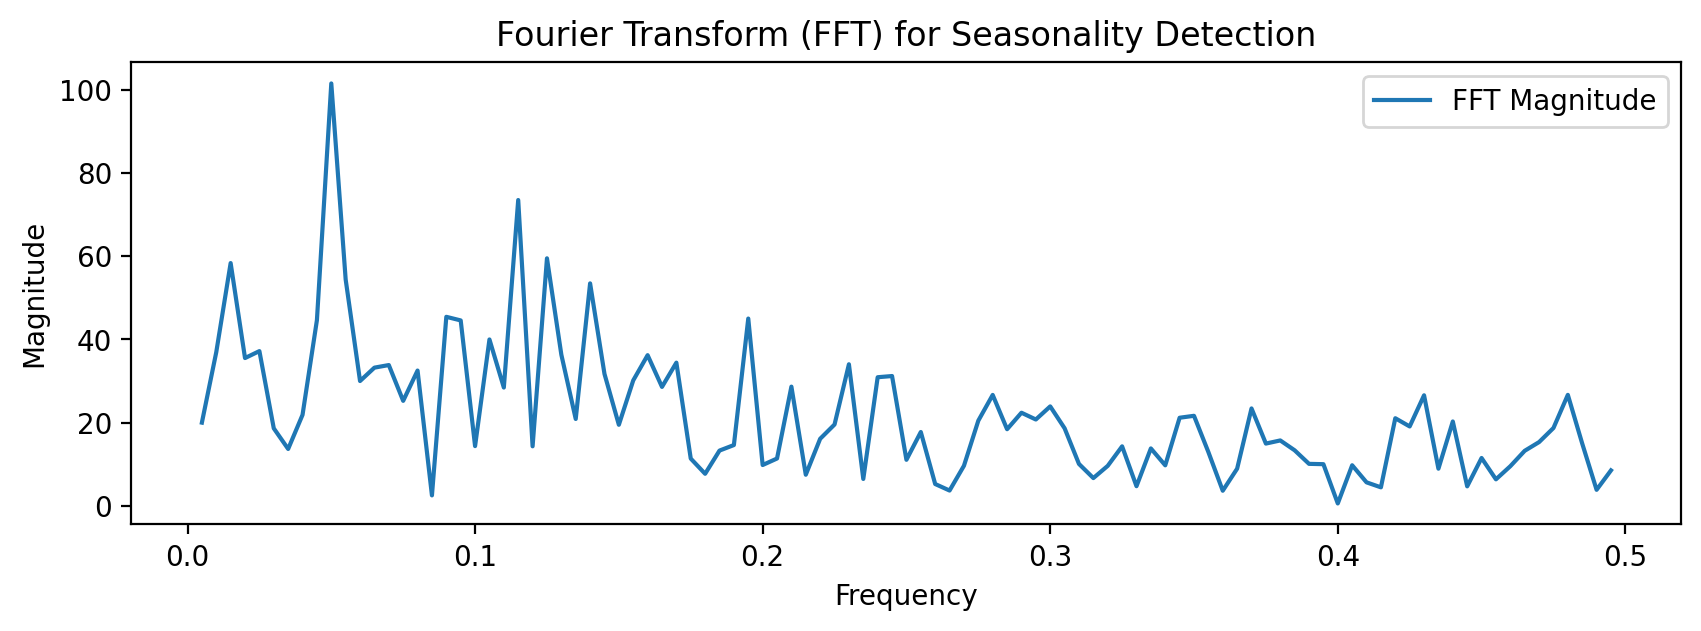

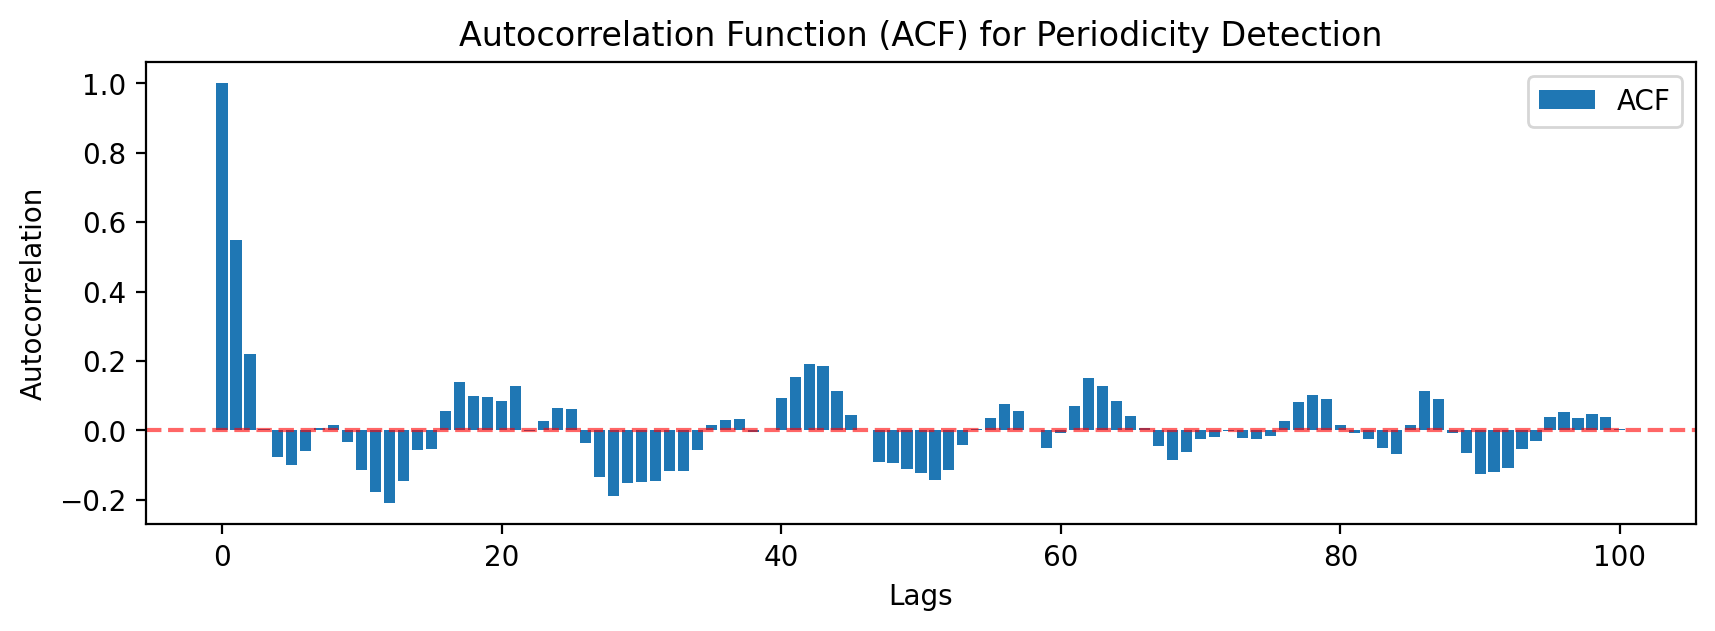

p-value: 0.0000


In [136]:
from statsmodels.tsa.arima_process import ArmaProcess

def simulate_seasonal_arma(nT=200, S=30, A=1, ar_params=[0.6, -0.3], ma_params=[0.4], noise_std=1):
    """
    Simulates an ARMA time series with an added seasonal component (sinusoidal pattern).
    Parameters:
        nT (int): Number of time points.
        S (int): Seasonal period.
        A (float): Amplitude of seasonal cycle.
        ar_params (list): AR coefficients (without leading 1).
        ma_params (list): MA coefficients (without leading 1).
        noise_std (float): Standard deviation of noise.
    """
    # Create AR and MA polynomials
    ar = np.r_[1, -np.array(ar_params)]  # Include leading 1 for AR process
    ma = np.r_[1, np.array(ma_params)]  # Include leading 1 for MA process

    # Generate ARMA process
    arma_process = ArmaProcess(ar, ma)
    arma_data = arma_process.generate_sample(nsample=nT)

    # Generate seasonal component (sinusoidal pattern)
    seasonal_component = A * np.sin(2 * np.pi * np.arange(nT) / S)

    # Generate white noise
    noise = np.random.normal(scale=noise_std, size=nT)

    # Combine components
    seasonal_arma_data = seasonal_component + arma_data + noise

    return seasonal_arma_data

# Simulate Data
nT = 200  # Number of time points
S = 20    # Seasonal period
simulated_data = simulate_seasonal_arma(nT=nT, S=S)

analyze_time_series(simulated_data)


In [133]:
import numpy as np
from scipy.fft import fft

def detect_seasonality_fft(time_series, sampling_rate=1, threshold=0.05):
    """
    Detects seasonality in a time series using Fourier Transform.

    Parameters:
        time_series (array-like): The time series data.
        sampling_rate (int): The sampling interval (default=1).
        threshold (float): Minimum relative power required to confirm seasonality.

    Returns:
        dominant_period (float or None): The most significant seasonal period, or None if no strong seasonality is found.
    """
    # Compute FFT
    fft_values = np.abs(fft(time_series))
    freqs = np.fft.fftfreq(len(time_series), d=sampling_rate)

    pos_freqs = freqs[freqs > 0]
    pos_fft_values = fft_values[freqs > 0]

    # Find the peak frequency
    dominant_freq_idx = np.argmax(pos_fft_values)
    dominant_freq = pos_freqs[dominant_freq_idx]

    # Convert frequency to period (T = 1/f)
    dominant_period = 1 / dominant_freq if dominant_freq > 0 else None

    # Check if power at dominant frequency is strong enough
    total_power = np.sum(pos_fft_values)
    dominant_power = pos_fft_values[dominant_freq_idx]

    if (dominant_power / total_power) > threshold:
        return round(dominant_period, 2)  # Return estimated seasonal period
    else:
        return None  # No strong seasonality detected

# Example Usage
seasonality = detect_seasonality_fft(sim_data.flatten())
# seasonality = detect_seasonality_fft(simulated_data)
print("Detected Seasonality Period:", seasonality)


Detected Seasonality Period: 62.5
